# Binary Classification

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/mbarbetti/lymphoma-classification/blob/master/3_binary_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/mbarbetti/lymphoma-classification/blob/master/3_binary_classification.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection  import StratifiedShuffleSplit
from sklearn.preprocessing    import MinMaxScaler
from imblearn.over_sampling   import SMOTE
from sklearn.dummy            import DummyClassifier
from sklearn.linear_model     import LogisticRegression
from sklearn.svm              import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble         import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics          import confusion_matrix, roc_curve, roc_auc_score

from utils import custom_predictions, plot_conf_matrices, plot_decision_boundary

LABELS = ["cHL", "PMBCL"]

## Data loading and preparation

In [2]:
data_dir  = "./data"
data_file = "db_mediastinalbulky_reduced.pkl" 
file_path = os.path.join ( data_dir, data_file )

with open (file_path, "rb") as file:
  data = pickle.load (file)

data . info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119 entries, 0 to 118
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   ID                                    119 non-null    float64
 1   lymphoma_type                         119 non-null    float64
 2   CONVENTIONAL_SUVbwmax                 119 non-null    float64
 3   CONVENTIONAL_SUVbwmean                119 non-null    float64
 4   CONVENTIONAL_TLG(mL)[onlyForPETorNM]  119 non-null    float64
 5   CONVENTIONAL_SUVbwSkewness            119 non-null    float64
 6   CONVENTIONAL_SUVbwKurtosis            119 non-null    float64
 7   GLCM_Homogeneity[=InverseDifference]  119 non-null    float64
 8   GLCM_Entropy_log10                    119 non-null    float64
 9   GLRLM_SRE                             119 non-null    float64
 10  GLRLM_LRE                             119 non-null    float64
 11  GLZLM_LGZE         

### Input/output preparation

In [3]:
cols = list ( data.columns )
X_cols = cols[2:]
y_cols = "lymphoma_type"

id = data.query("lymphoma_type != 2")["ID"]   . to_numpy() . flatten()
X  = data.query("lymphoma_type != 2")[X_cols] . to_numpy()
y  = data.query("lymphoma_type != 2")[y_cols] . to_numpy() . flatten()
y  = ( y == 3 )   # PMBCL/cHL classification

ratio = len(y[y == True]) / len(y[y == False])
print ( "PMBCL-cHL ratio on data-set : {:.1f}%" . format (100 * ratio) )

PMBCL-cHL ratio on data-set : 35.8%


### Train-set and test-set splitting

In [4]:
sss = StratifiedShuffleSplit ( n_splits = 1, test_size = 0.2 )
for idx_train, idx_test in sss . split ( X, y ):
  X_train , y_train , id_train = X[idx_train] , y[idx_train] , id[idx_train]
  X_test  , y_test  , id_test  = X[idx_test]  , y[idx_test]  , id[idx_test]

### Train-set
ratio_train = len(y_train[y_train == True]) / len(y_train[y_train == False])
print ( "PMBCL-cHL ratio on train-set : {:.1f}%" . format (100 * ratio_train) )

### Test-set
ratio_test = len(y_test[y_test == True]) / len(y_test[y_test == False])
print ( "PMBCL-cHL ratio on test-set  : {:.1f}%" . format (100 * ratio_test) )

PMBCL-cHL ratio on train-set : 35.4%
PMBCL-cHL ratio on test-set  : 37.5%


In [5]:
print ( f"First 5 IDs on train-set : {id_train[:5].astype(np.int32)}" )
print ( f"First 5 IDs on test-set  : {id_test[:5].astype(np.int32)}" )

First 5 IDs on train-set : [ 30  23  35  47 109]
First 5 IDs on test-set  : [66 71 70 44 62]


### Data preprocessing

In [6]:
scaler = MinMaxScaler()

X_train_original = X_train

X_train = scaler . fit_transform ( X_train )
X_test  = scaler . transform ( X_test )

print ( f"Resulting mean on train-set : {np.mean(X_train, axis = 0)}" )
print ( f"Resulting mean on test-set  : {np.mean(X_test, axis = 0)}" )

Resulting mean on train-set : [0.36274634 0.29659175 0.16358314 0.24849048 0.05958304 0.38872577
 0.57501387 0.69540458 0.25343181 0.31935941 0.24162287]
Resulting mean on test-set  : [0.43338475 0.38147187 0.19635728 0.2160446  0.04357396 0.32678875
 0.66139505 0.74530217 0.20951694 0.24530973 0.31820773]


In [7]:
sm = SMOTE()   # oversampling technique
X_train_res, y_train_res = sm.fit_resample ( X_train , y_train )

### Resampled train-set
ratio_train_res = len(y_train_res[y_train_res == True]) / len(y_train_res[y_train_res == False])
print ( "PMBCL-cHL ratio on resampled train-set : {:.1f}%" . format (100 * ratio_train_res) )

PMBCL-cHL ratio on resampled train-set : 100.0%


## Dummy classifier

In [8]:
clf_dummy = DummyClassifier (strategy = "stratified")
clf_dummy . fit ( X_train_res, y_train_res )   # training over resampled train-set

dummy_scores = clf_dummy . predict_proba ( X_train )
y_pred_dummy = ( dummy_scores[:,1] == 1 )   # predictions over original train-set

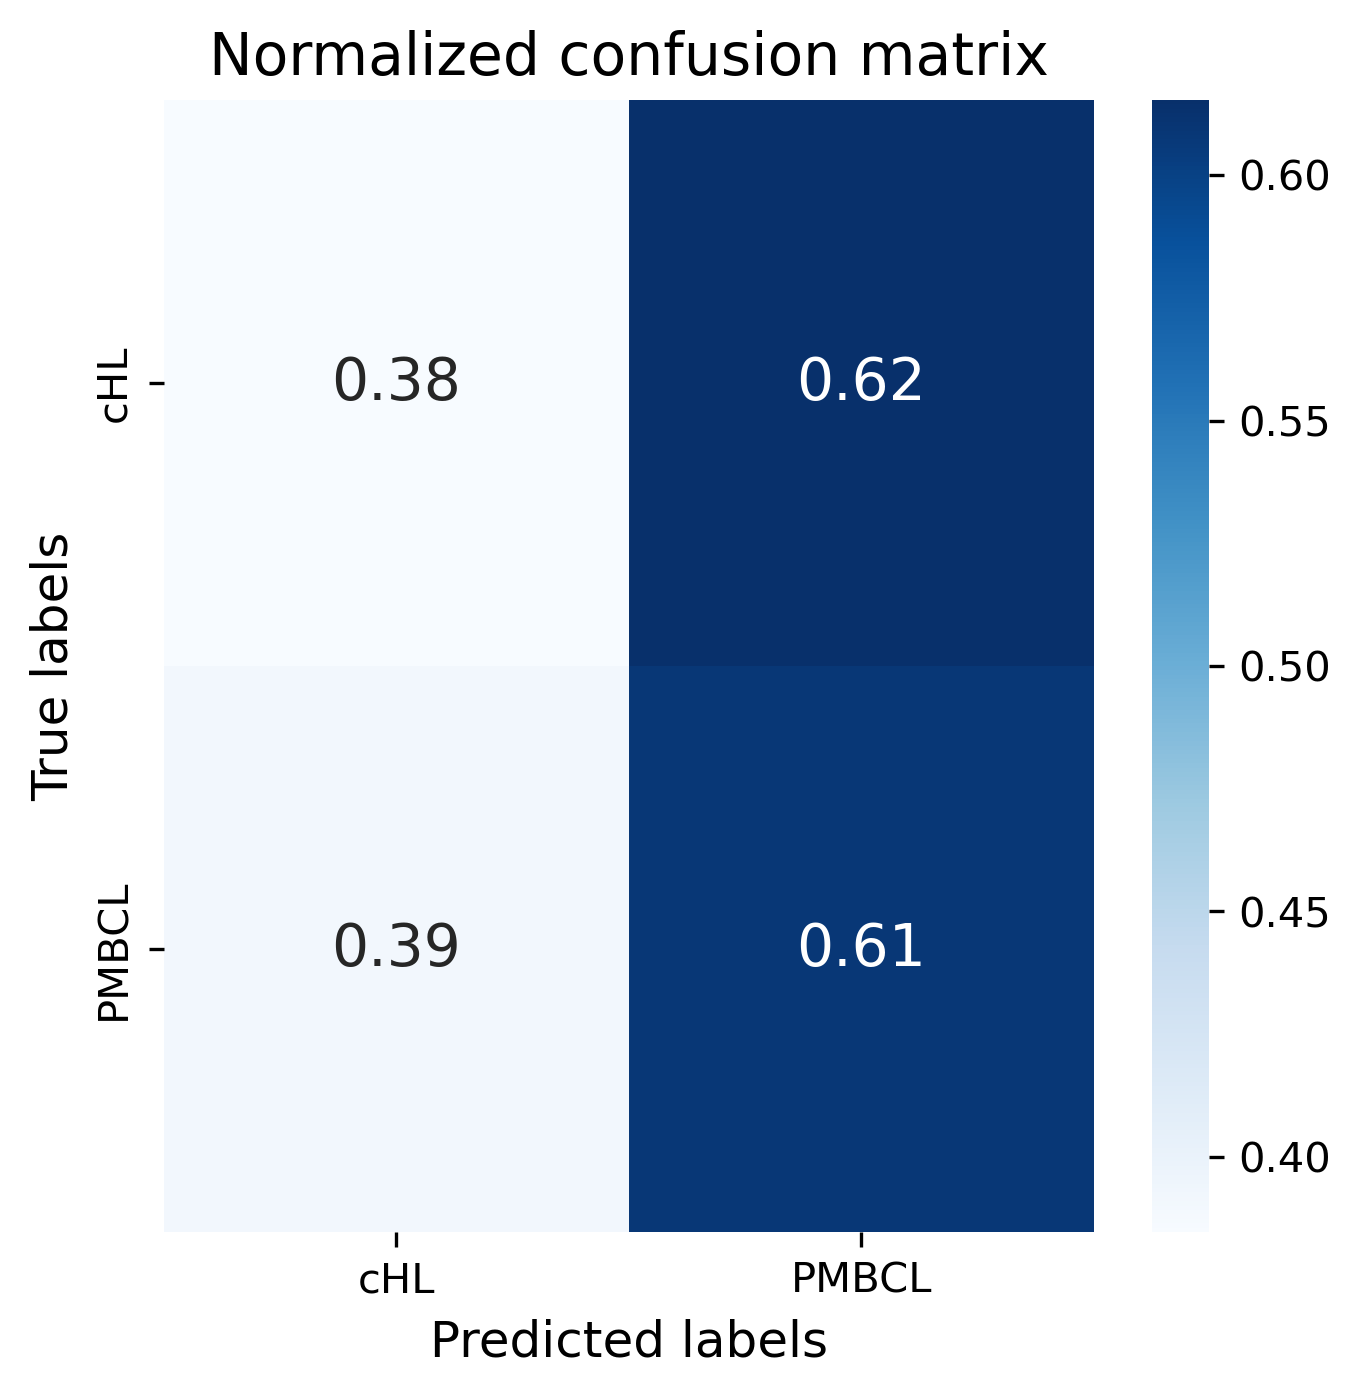

In [9]:
conf_matrix_train = confusion_matrix ( y_train, y_pred_dummy )

plot_conf_matrices ( conf_matrix = conf_matrix_train, labels = LABELS, show_matrix = "norm", save_figure = False )

## Logistic regression

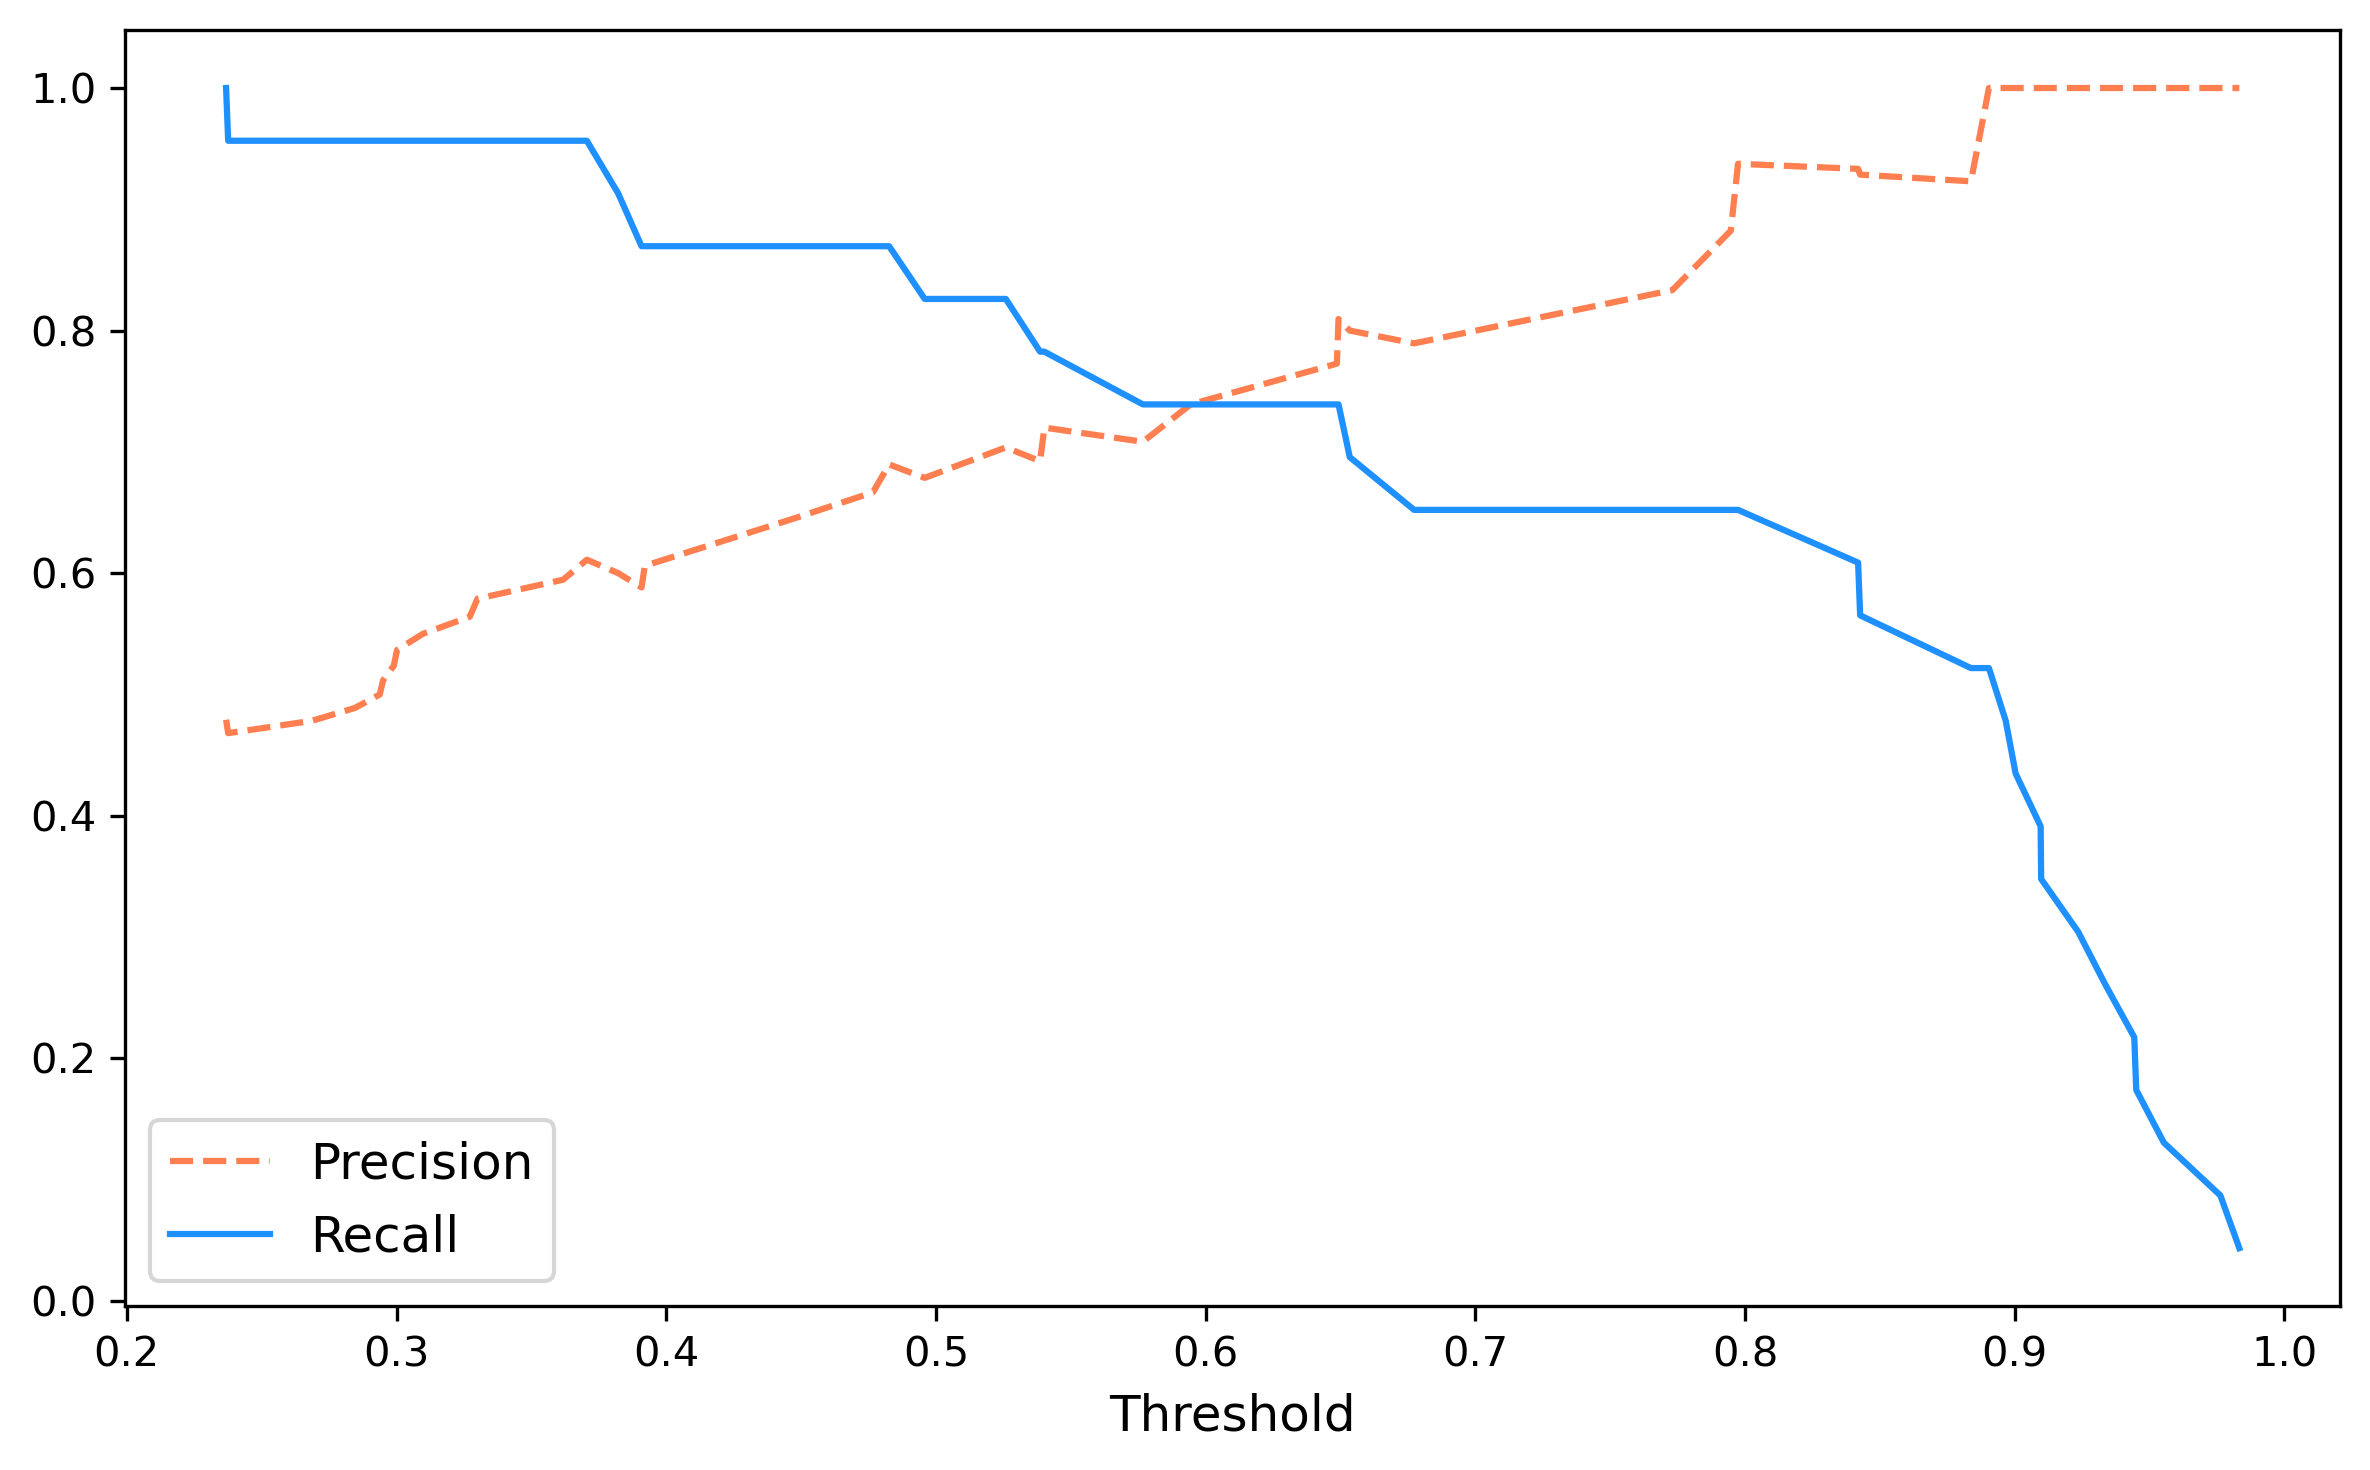

In [10]:
clf_logreg = LogisticRegression()
clf_logreg . fit ( X_train_res, y_train_res )

logreg_scores = clf_logreg . predict_proba ( X_train )
y_pred_logreg, _ = custom_predictions ( y_true   = y_train , 
                                        y_scores = logreg_scores , 
                                        recall_score    = 0.9  , 
                                        precision_score = None ,
                                        show_curves = True  , 
                                        save_figure = False )

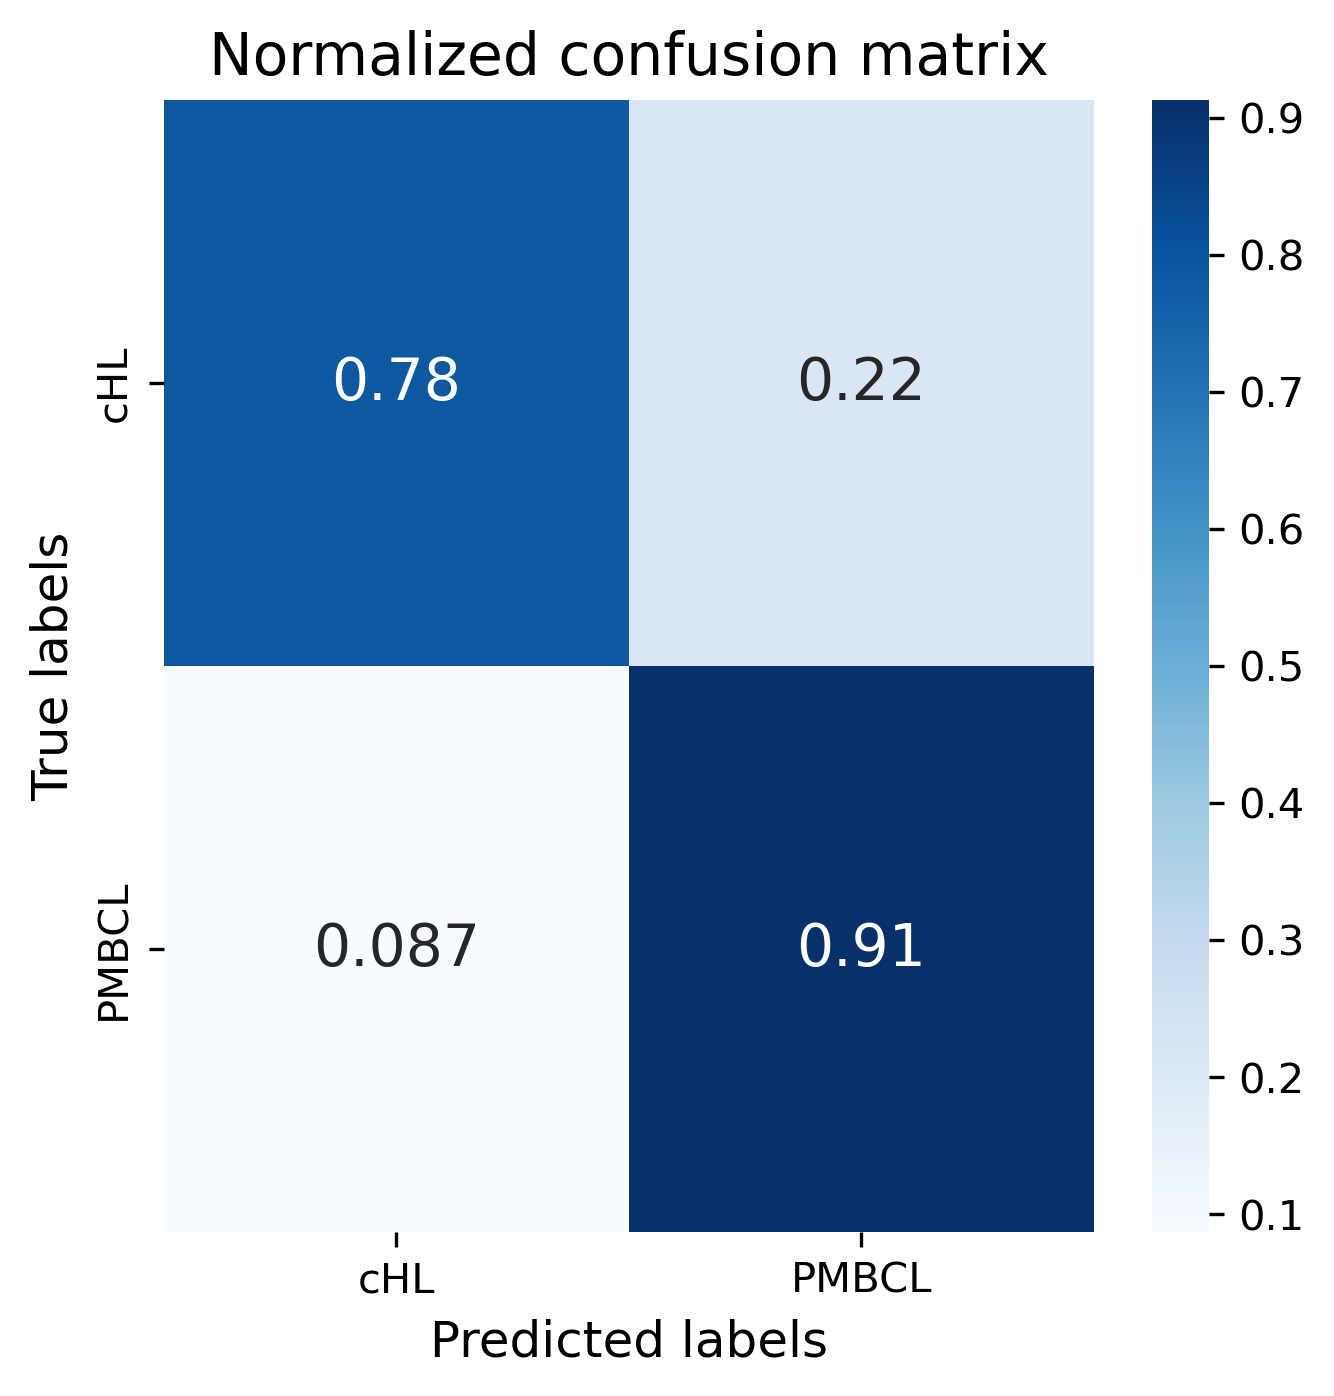

In [11]:
conf_matrix_train = confusion_matrix ( y_train, y_pred_logreg )

plot_conf_matrices ( conf_matrix = conf_matrix_train, labels = LABELS, show_matrix = "norm", save_figure = False )

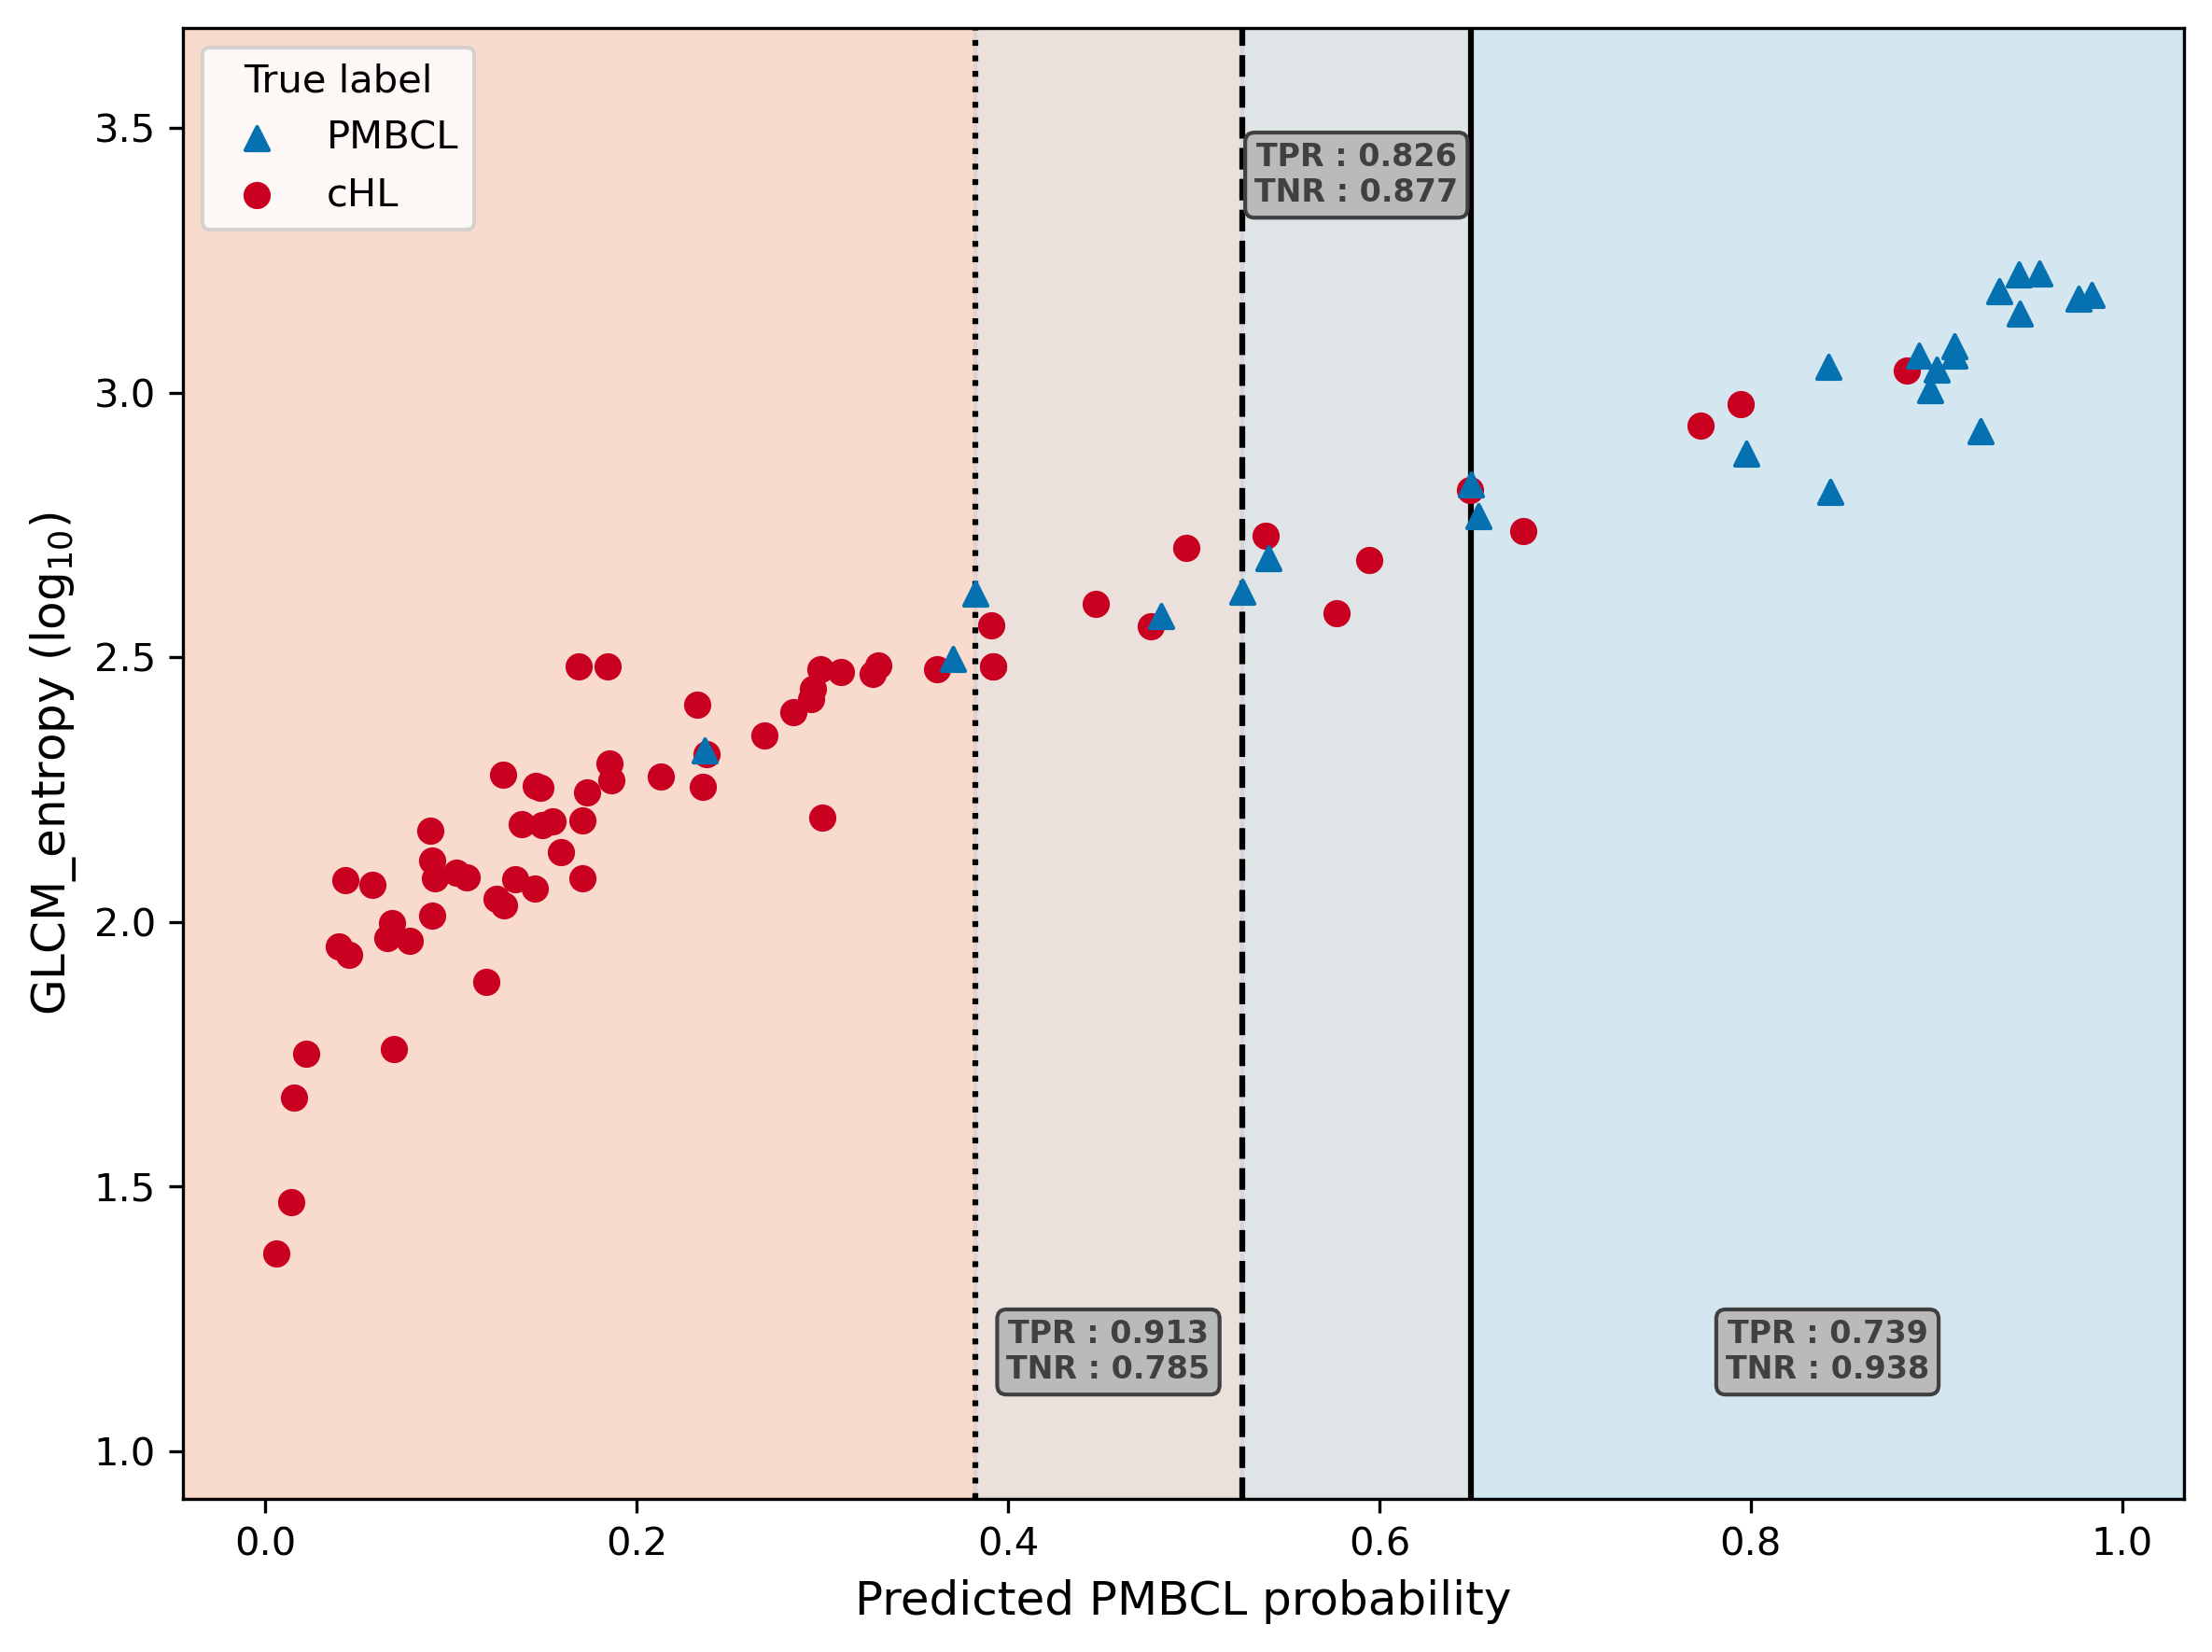

In [12]:
plot_decision_boundary ( y_true   = y_train , 
                         y_scores = logreg_scores ,
                         X_feat    = scaler . inverse_transform (X_train) [:,6] ,
                         feat_name = "GLCM_entropy ($\log_{10}$)" ,
                         strategy = "recall" , labels = LABELS , 
                         save_figure = False )

## Linear SVM

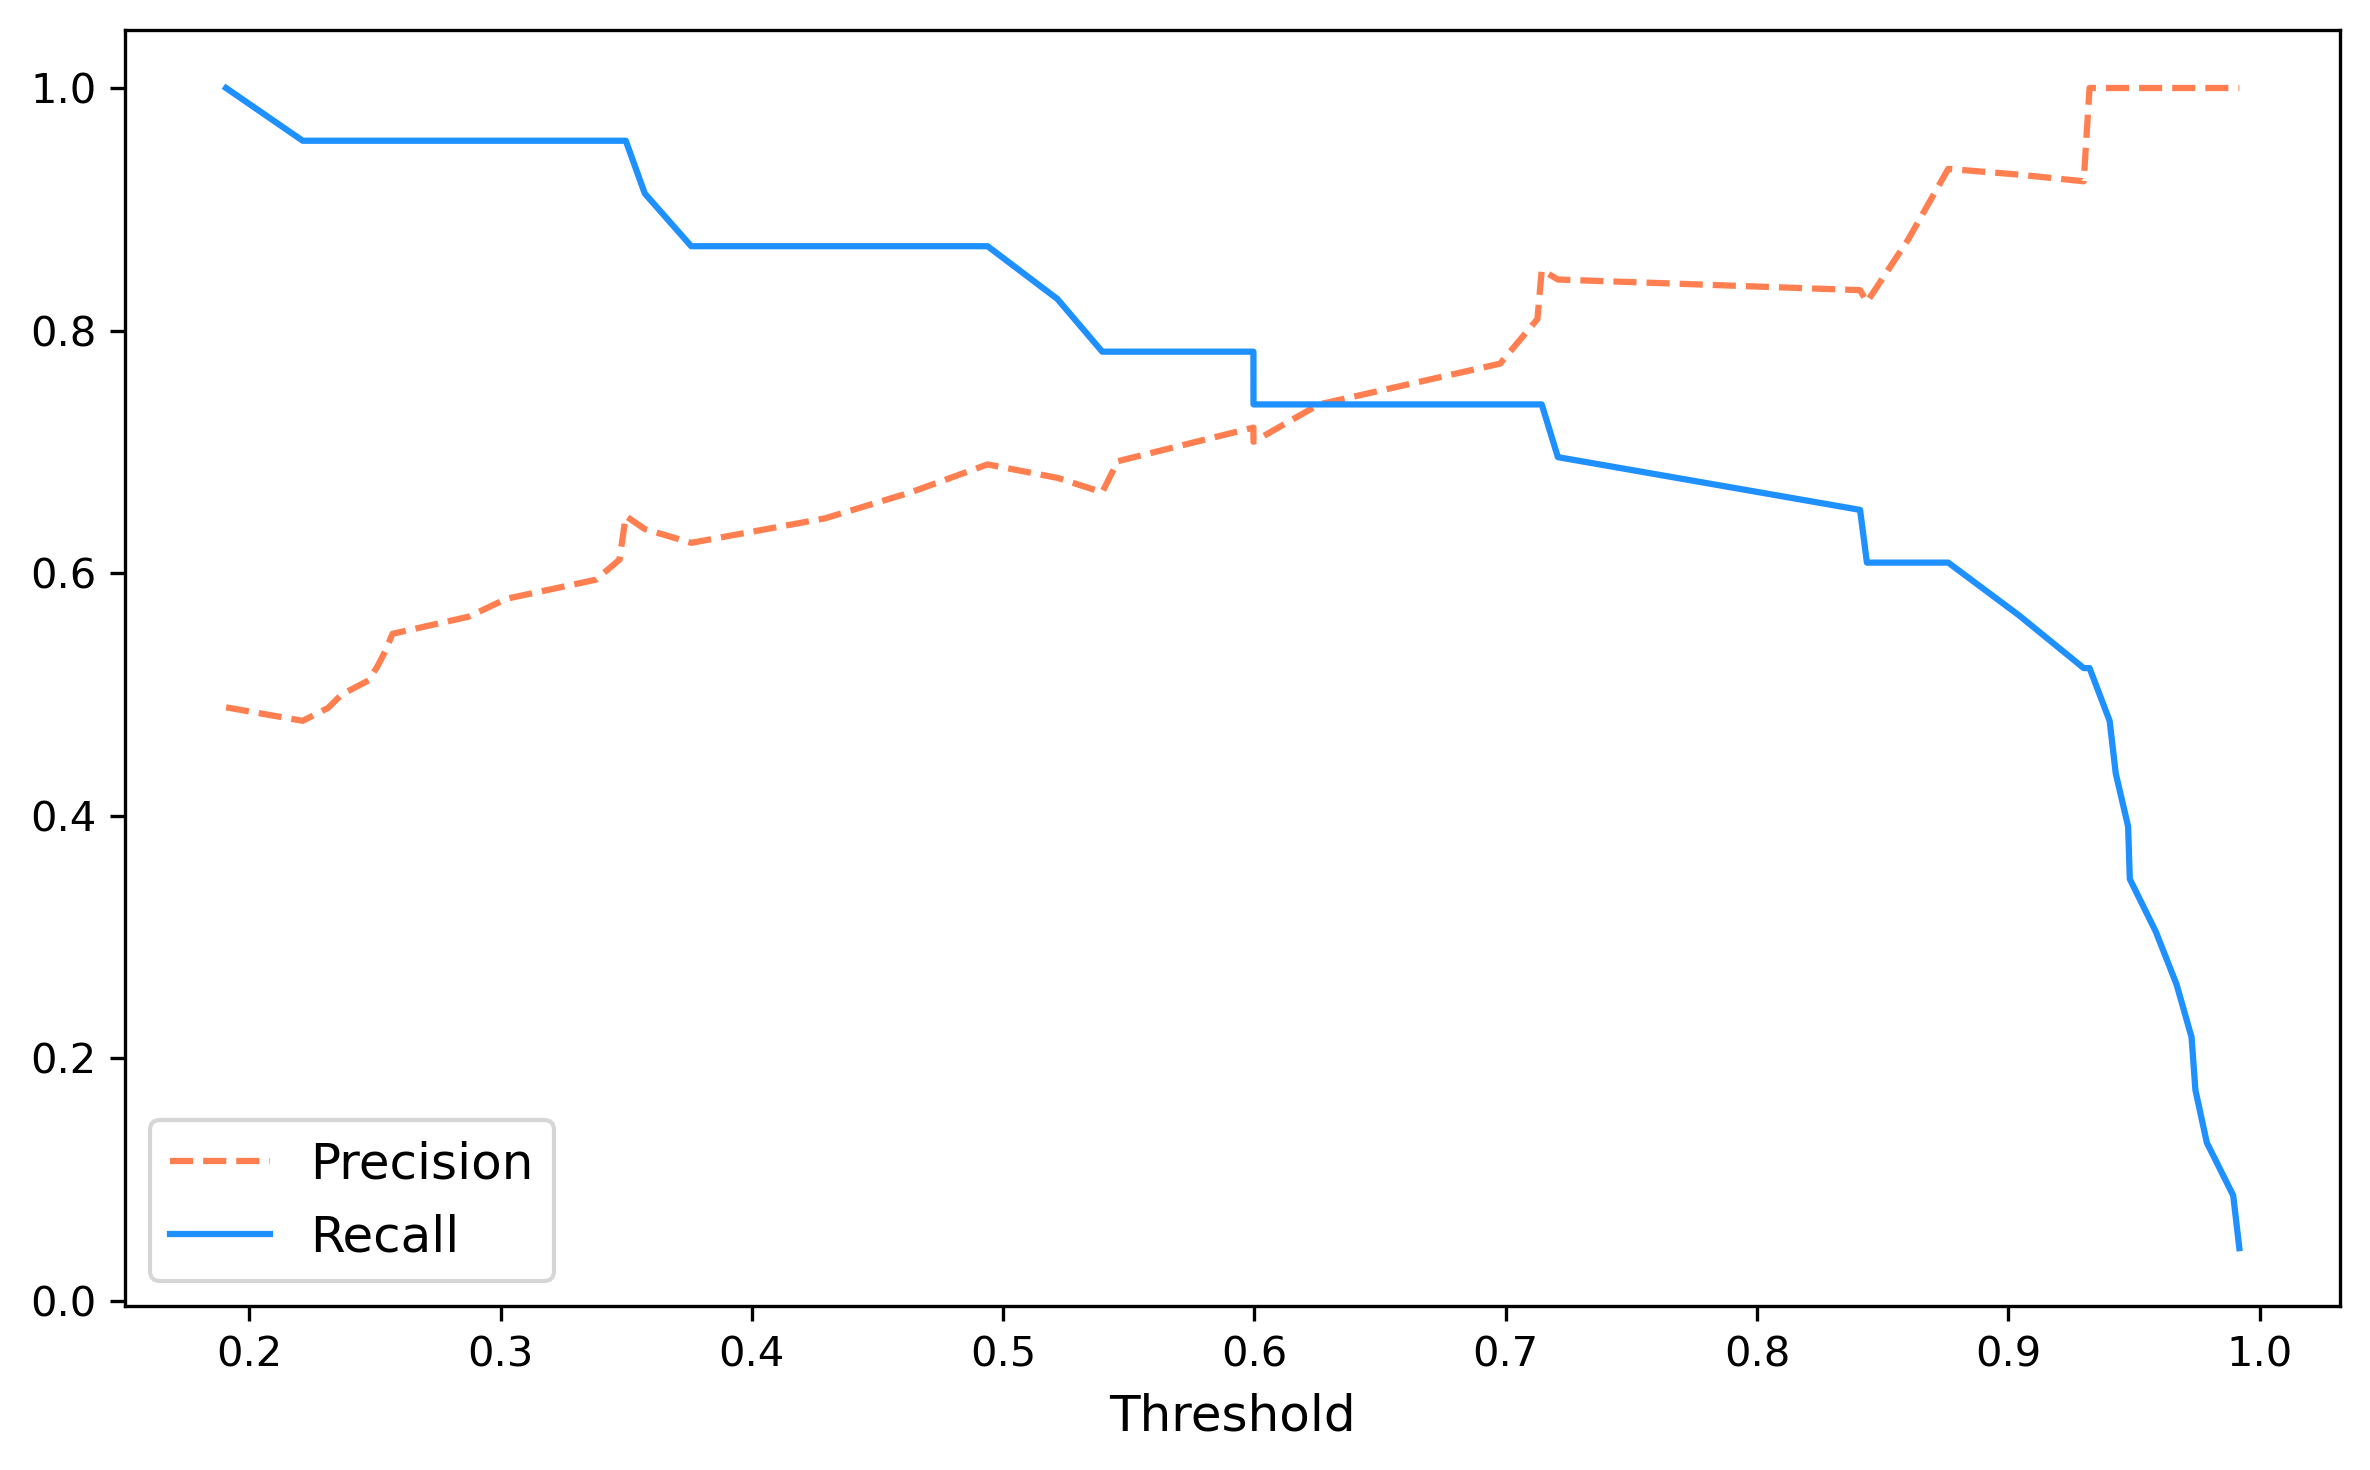

In [13]:
clf_linsvm = SVC ( kernel = "linear", probability = True )
clf_linsvm . fit ( X_train_res, y_train_res )

linsvm_scores = clf_linsvm . predict_proba ( X_train )
y_pred_linsvm, _ = custom_predictions ( y_true   = y_train , 
                                        y_scores = linsvm_scores , 
                                        recall_score    = 0.9  , 
                                        precision_score = None ,
                                        show_curves = True  , 
                                        save_figure = False )

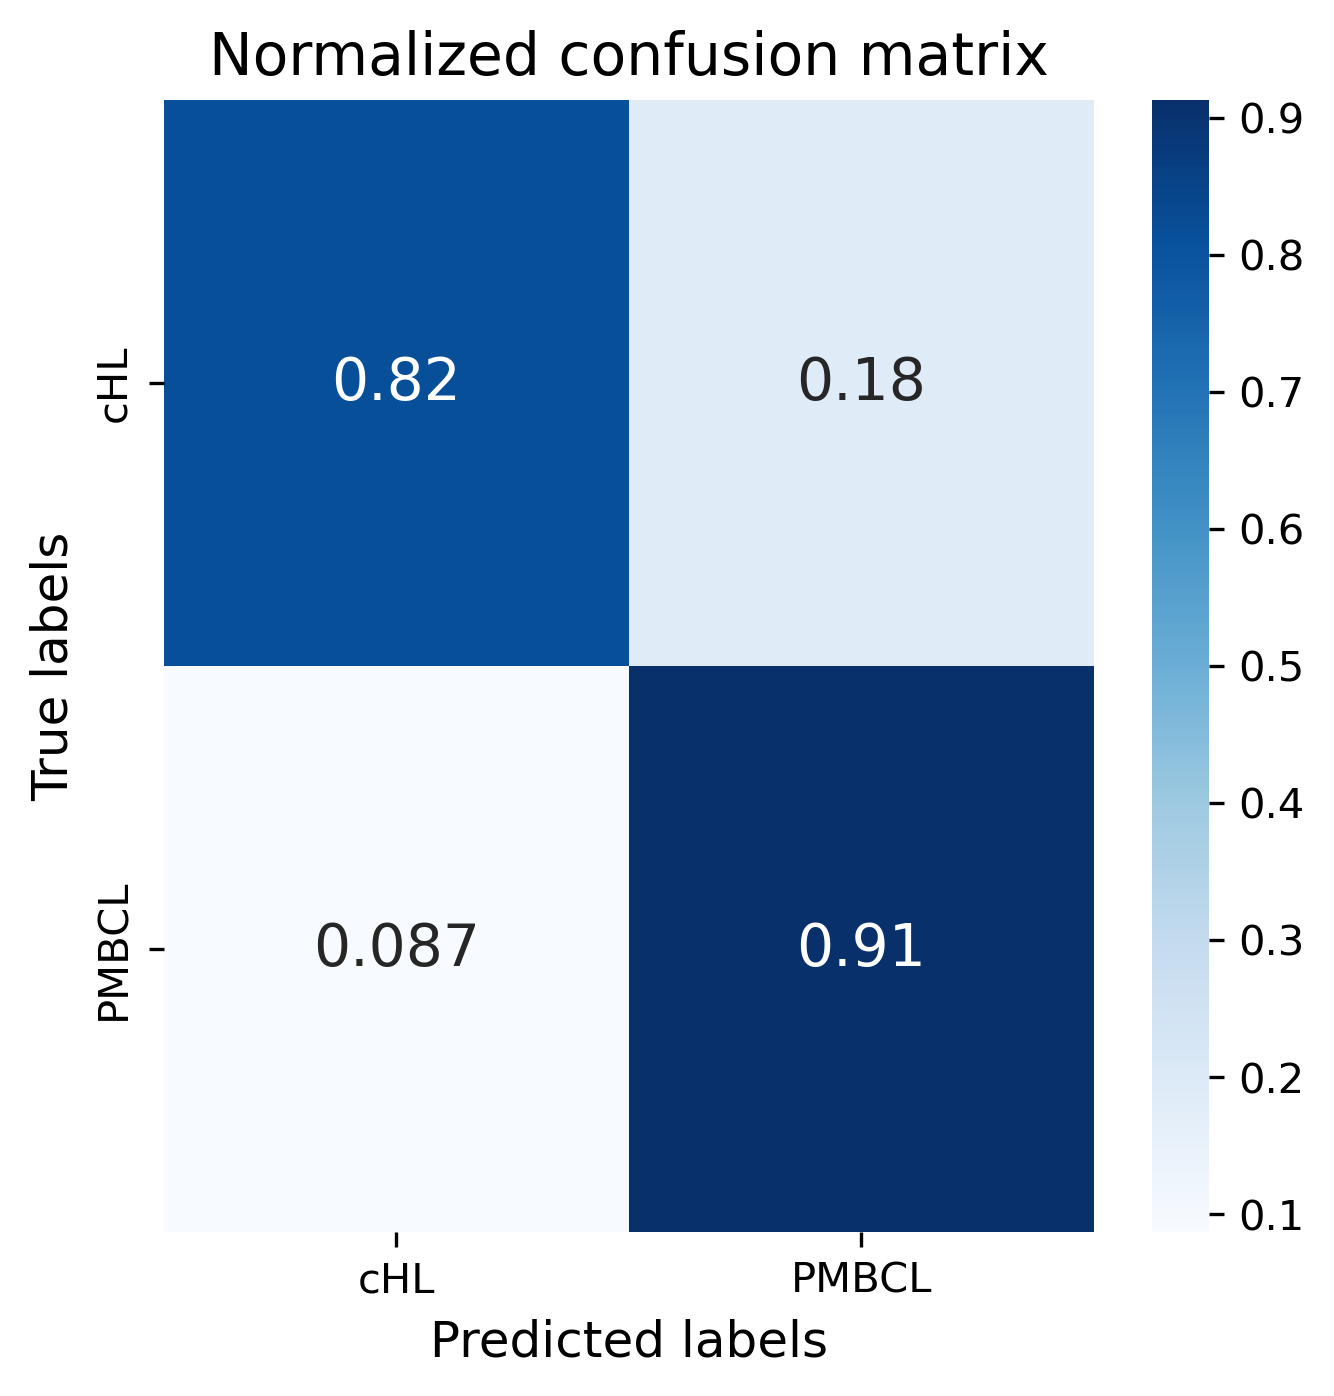

In [14]:
conf_matrix_train = confusion_matrix ( y_train, y_pred_linsvm )

plot_conf_matrices ( conf_matrix = conf_matrix_train, labels = LABELS, show_matrix = "norm", save_figure = False )

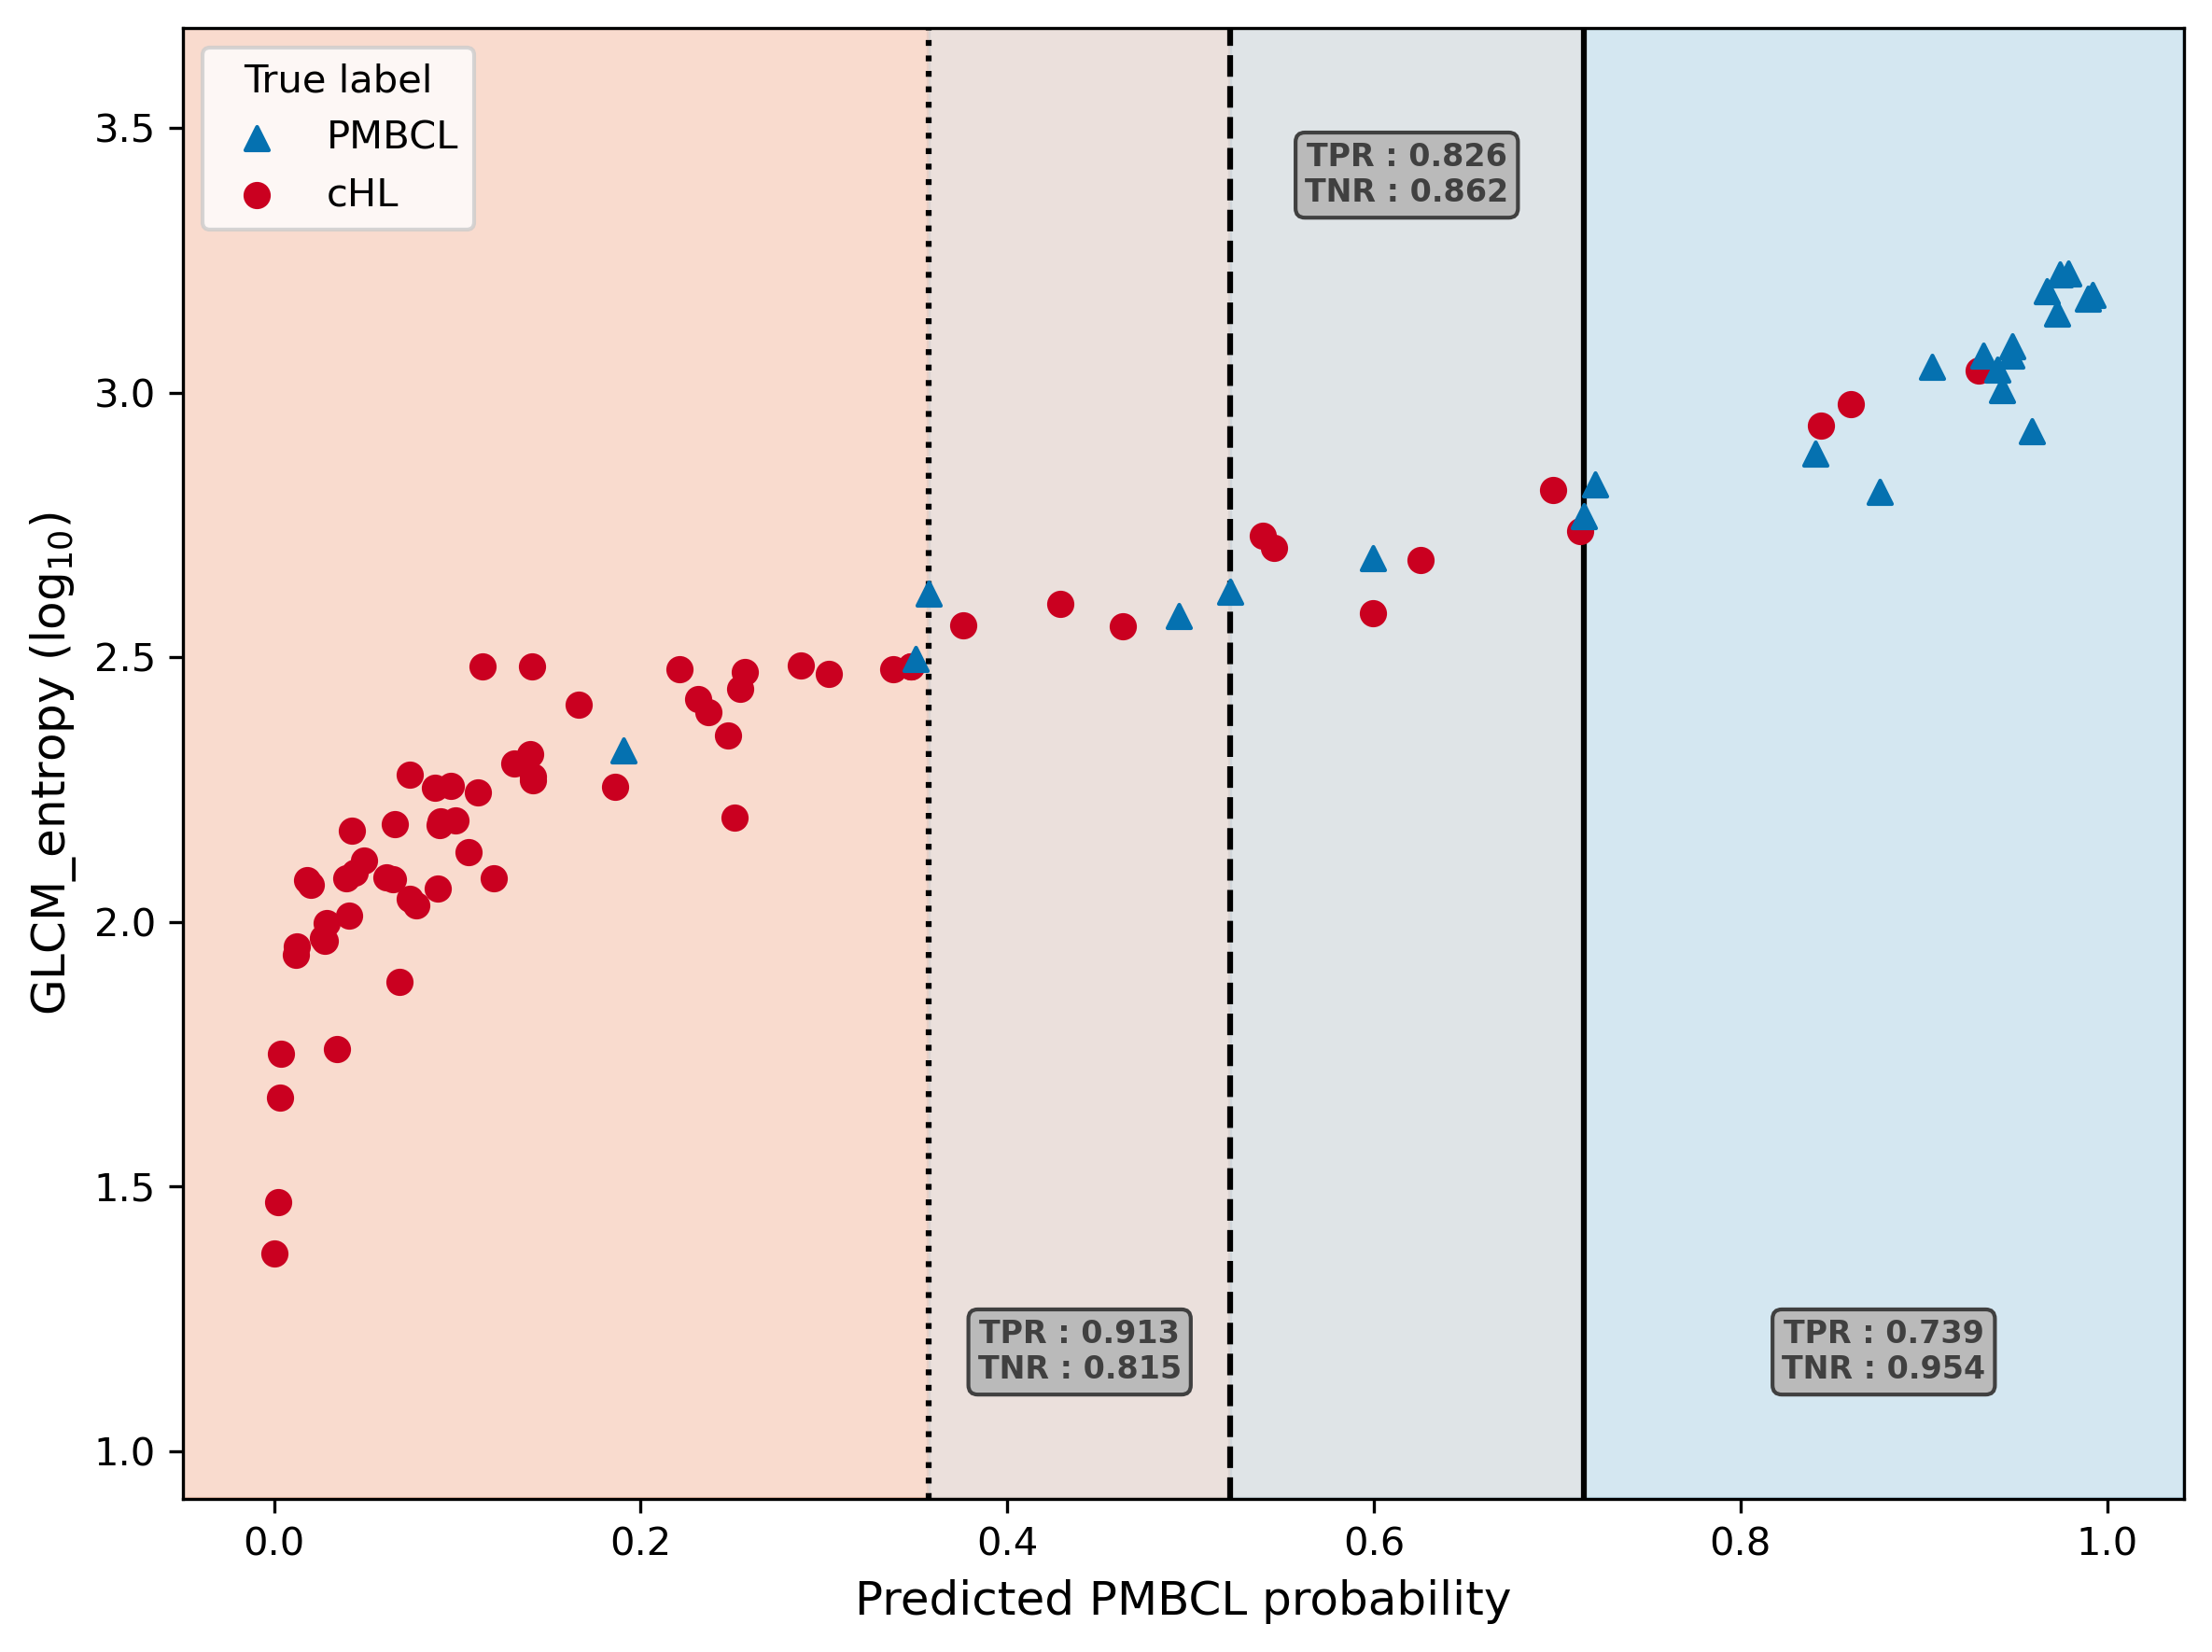

In [15]:
plot_decision_boundary ( y_true   = y_train , 
                         y_scores = linsvm_scores ,
                         X_feat    = scaler . inverse_transform (X_train) [:,6] ,
                         feat_name = "GLCM_entropy ($\log_{10}$)" ,
                         strategy = "recall" , labels = LABELS , 
                         save_figure = False )

## Gaussian process

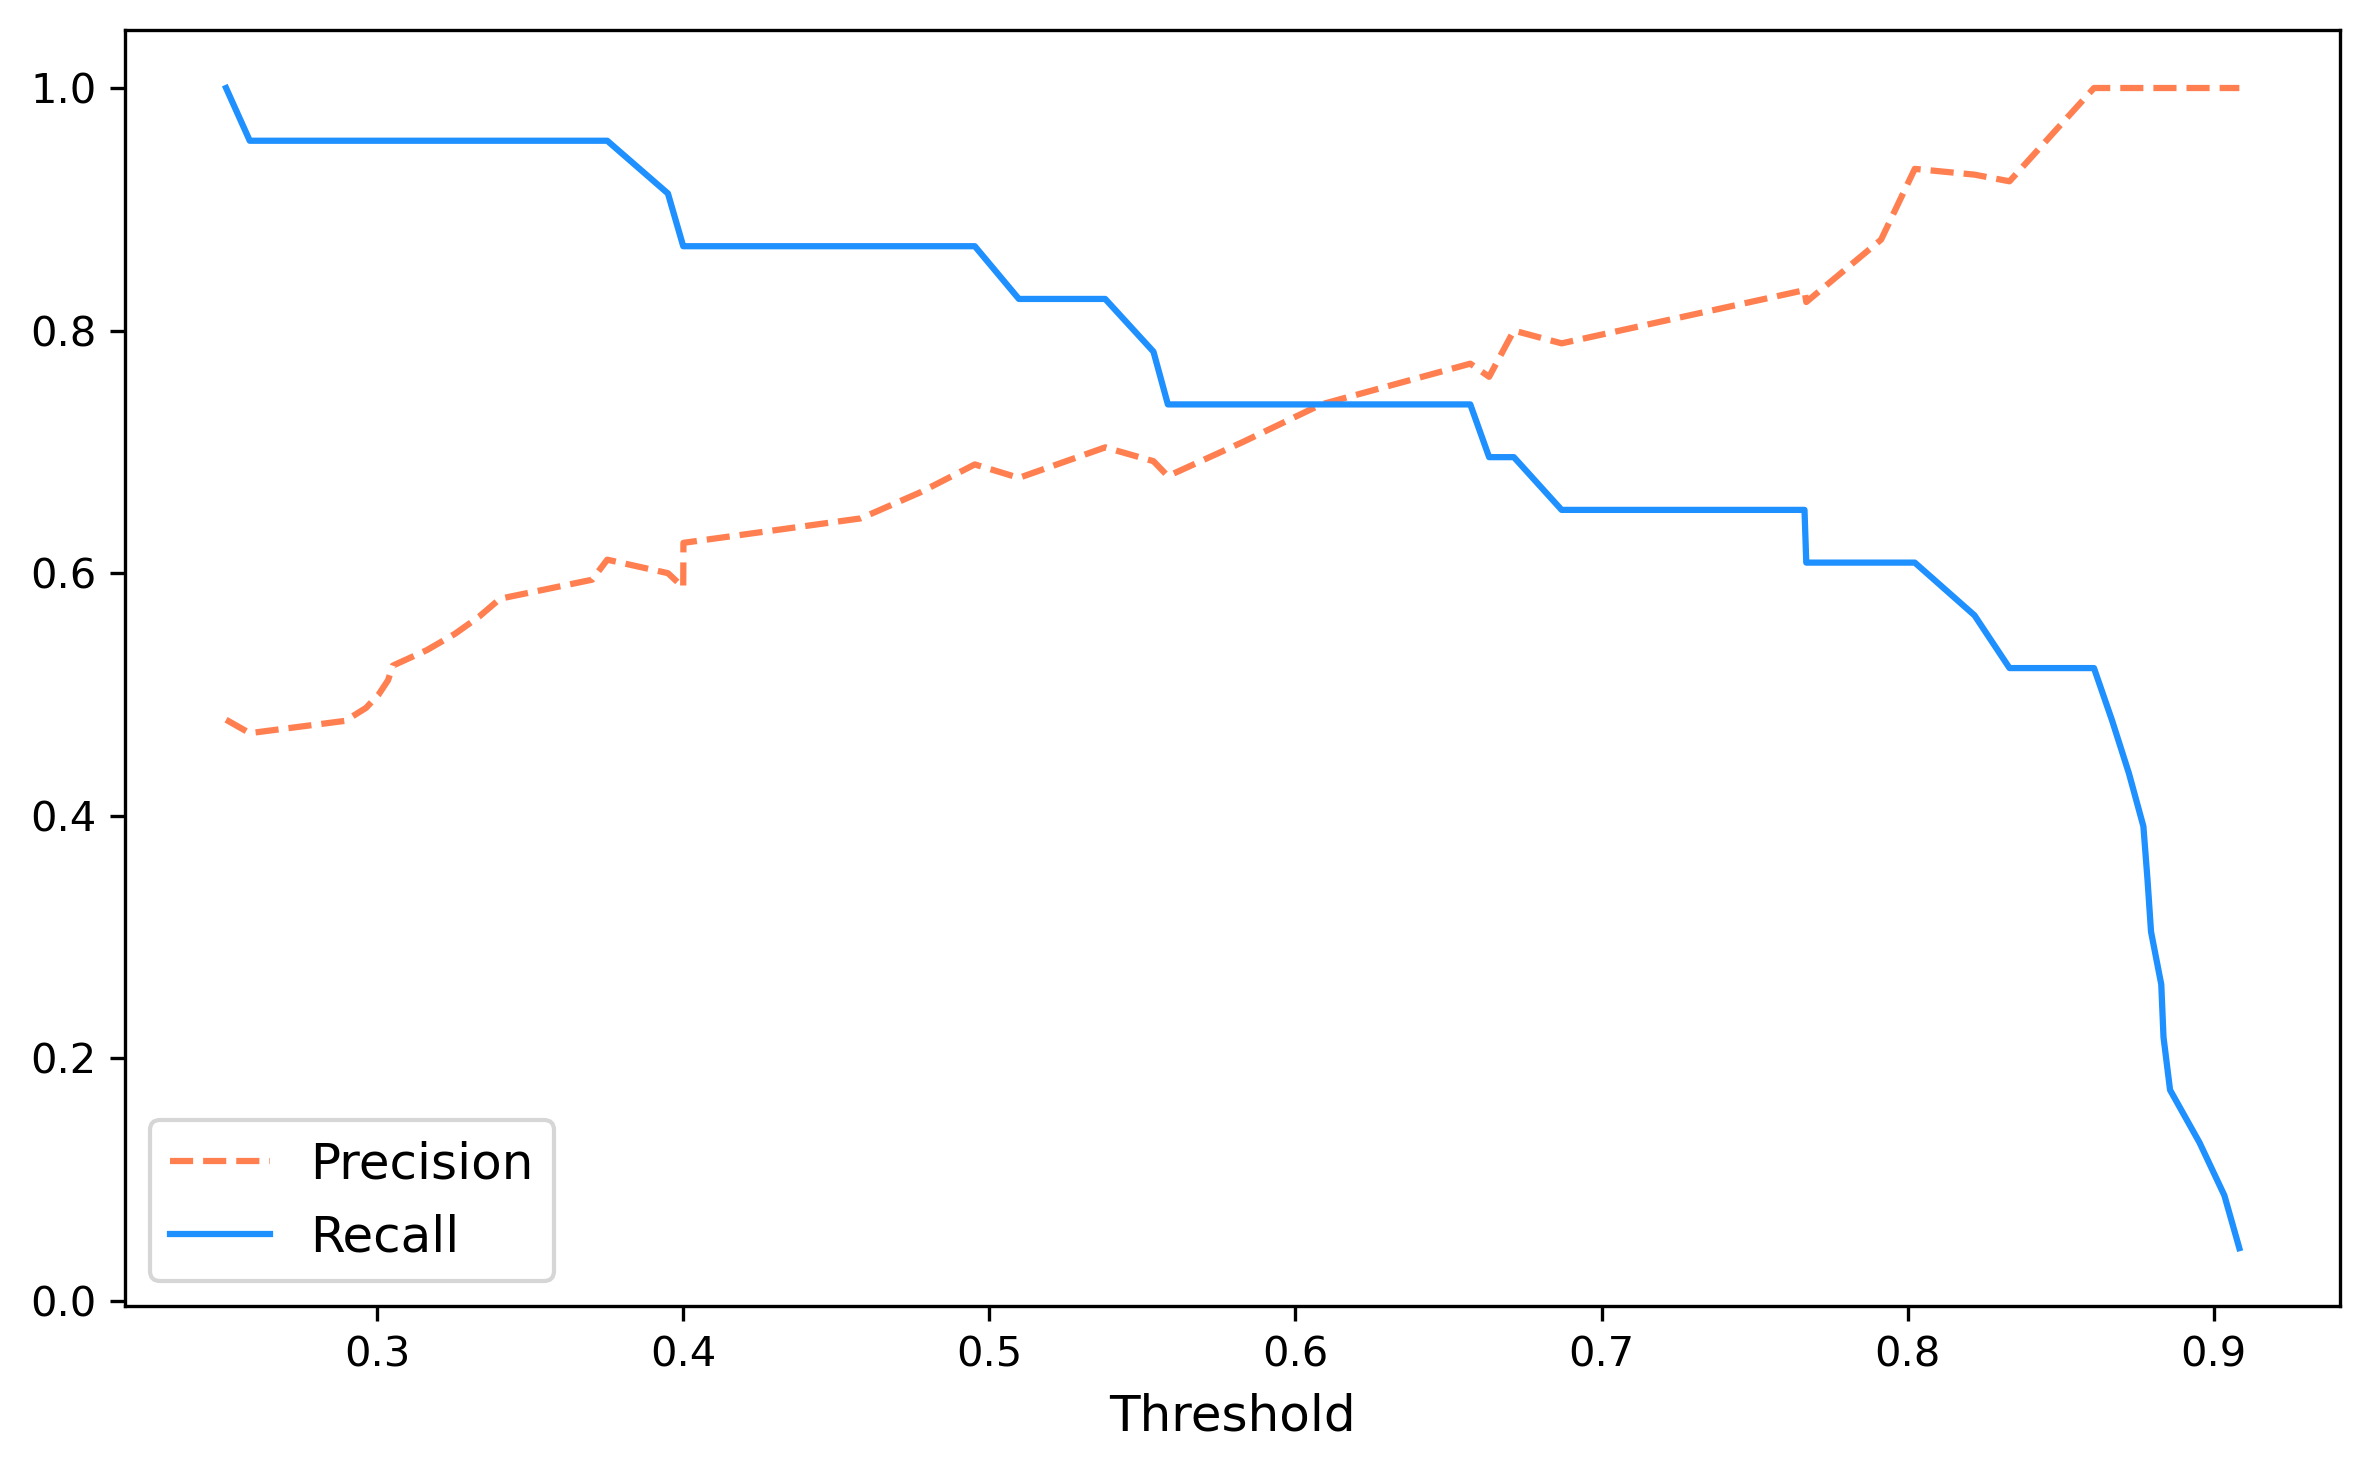

In [16]:
clf_gausproc = GaussianProcessClassifier()
clf_gausproc . fit ( X_train_res, y_train_res )

gausproc_scores = clf_gausproc . predict_proba ( X_train )
y_pred_gausproc, _ = custom_predictions ( y_true   = y_train , 
                                          y_scores = gausproc_scores , 
                                          recall_score    = 0.9  , 
                                          precision_score = None ,
                                          show_curves = True  , 
                                          save_figure = False )

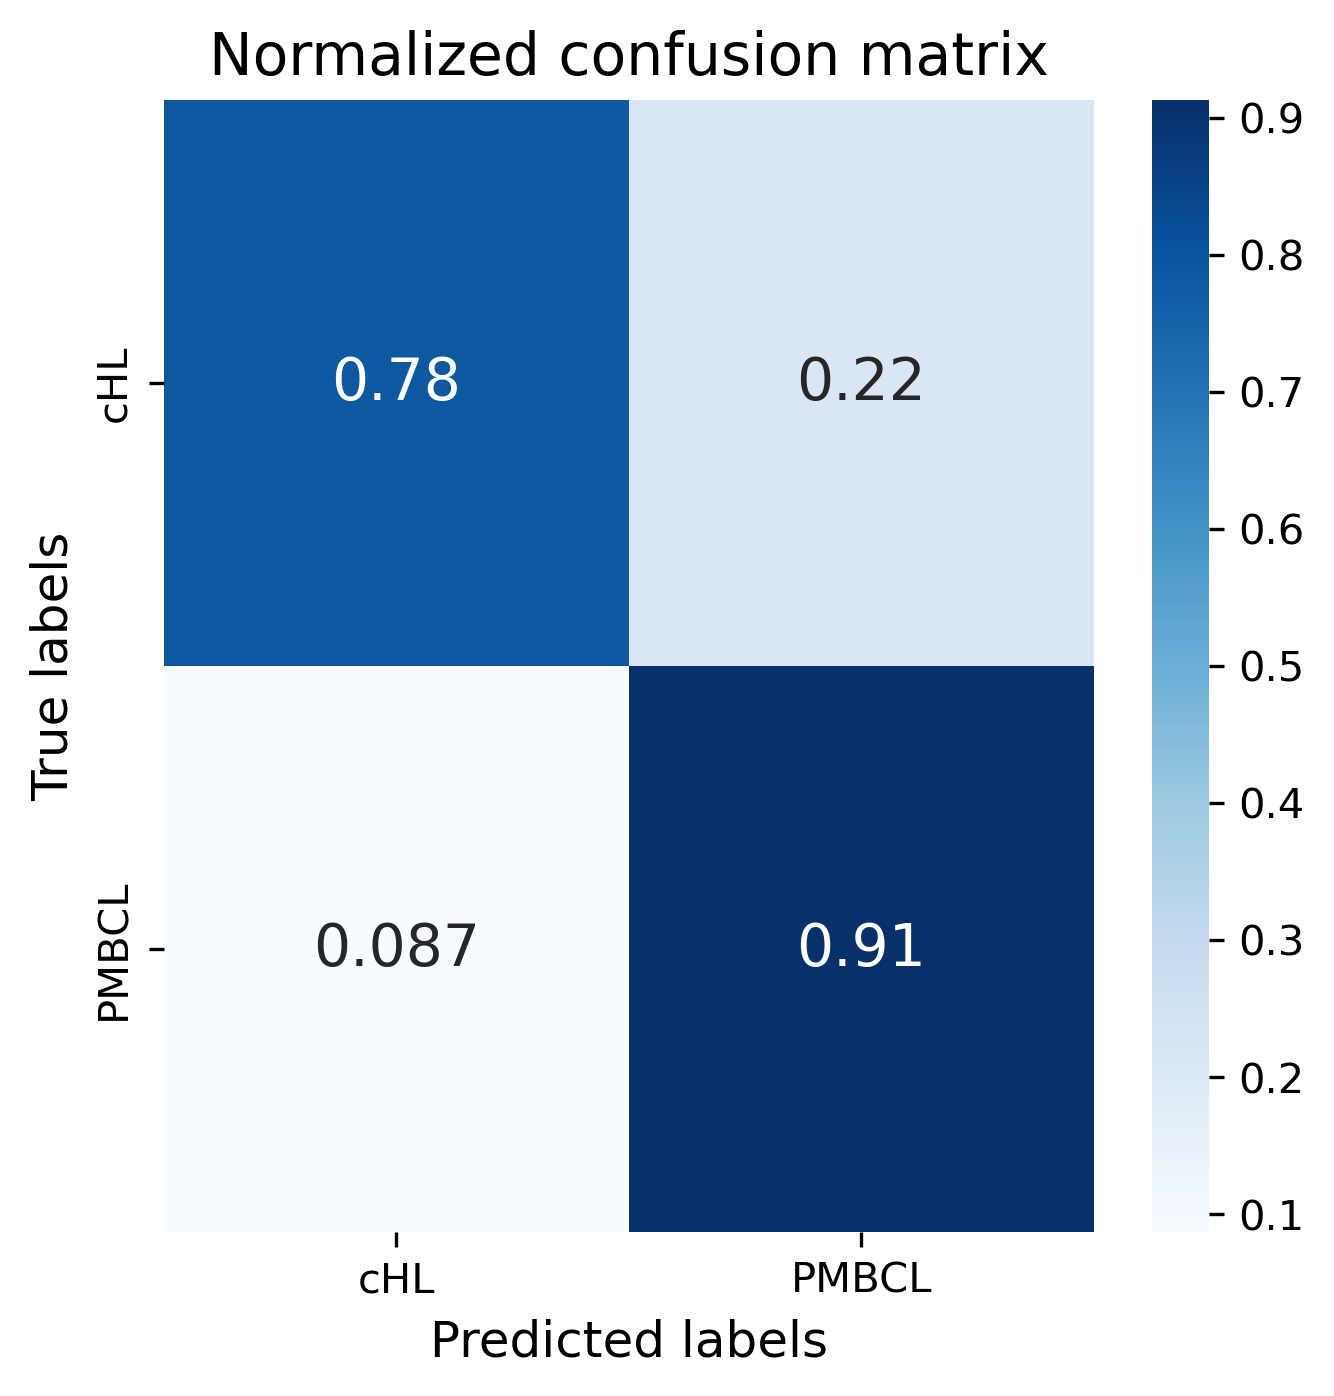

In [17]:
conf_matrix_train = confusion_matrix ( y_train, y_pred_gausproc )

plot_conf_matrices ( conf_matrix = conf_matrix_train, labels = LABELS, show_matrix = "norm", save_figure = False )

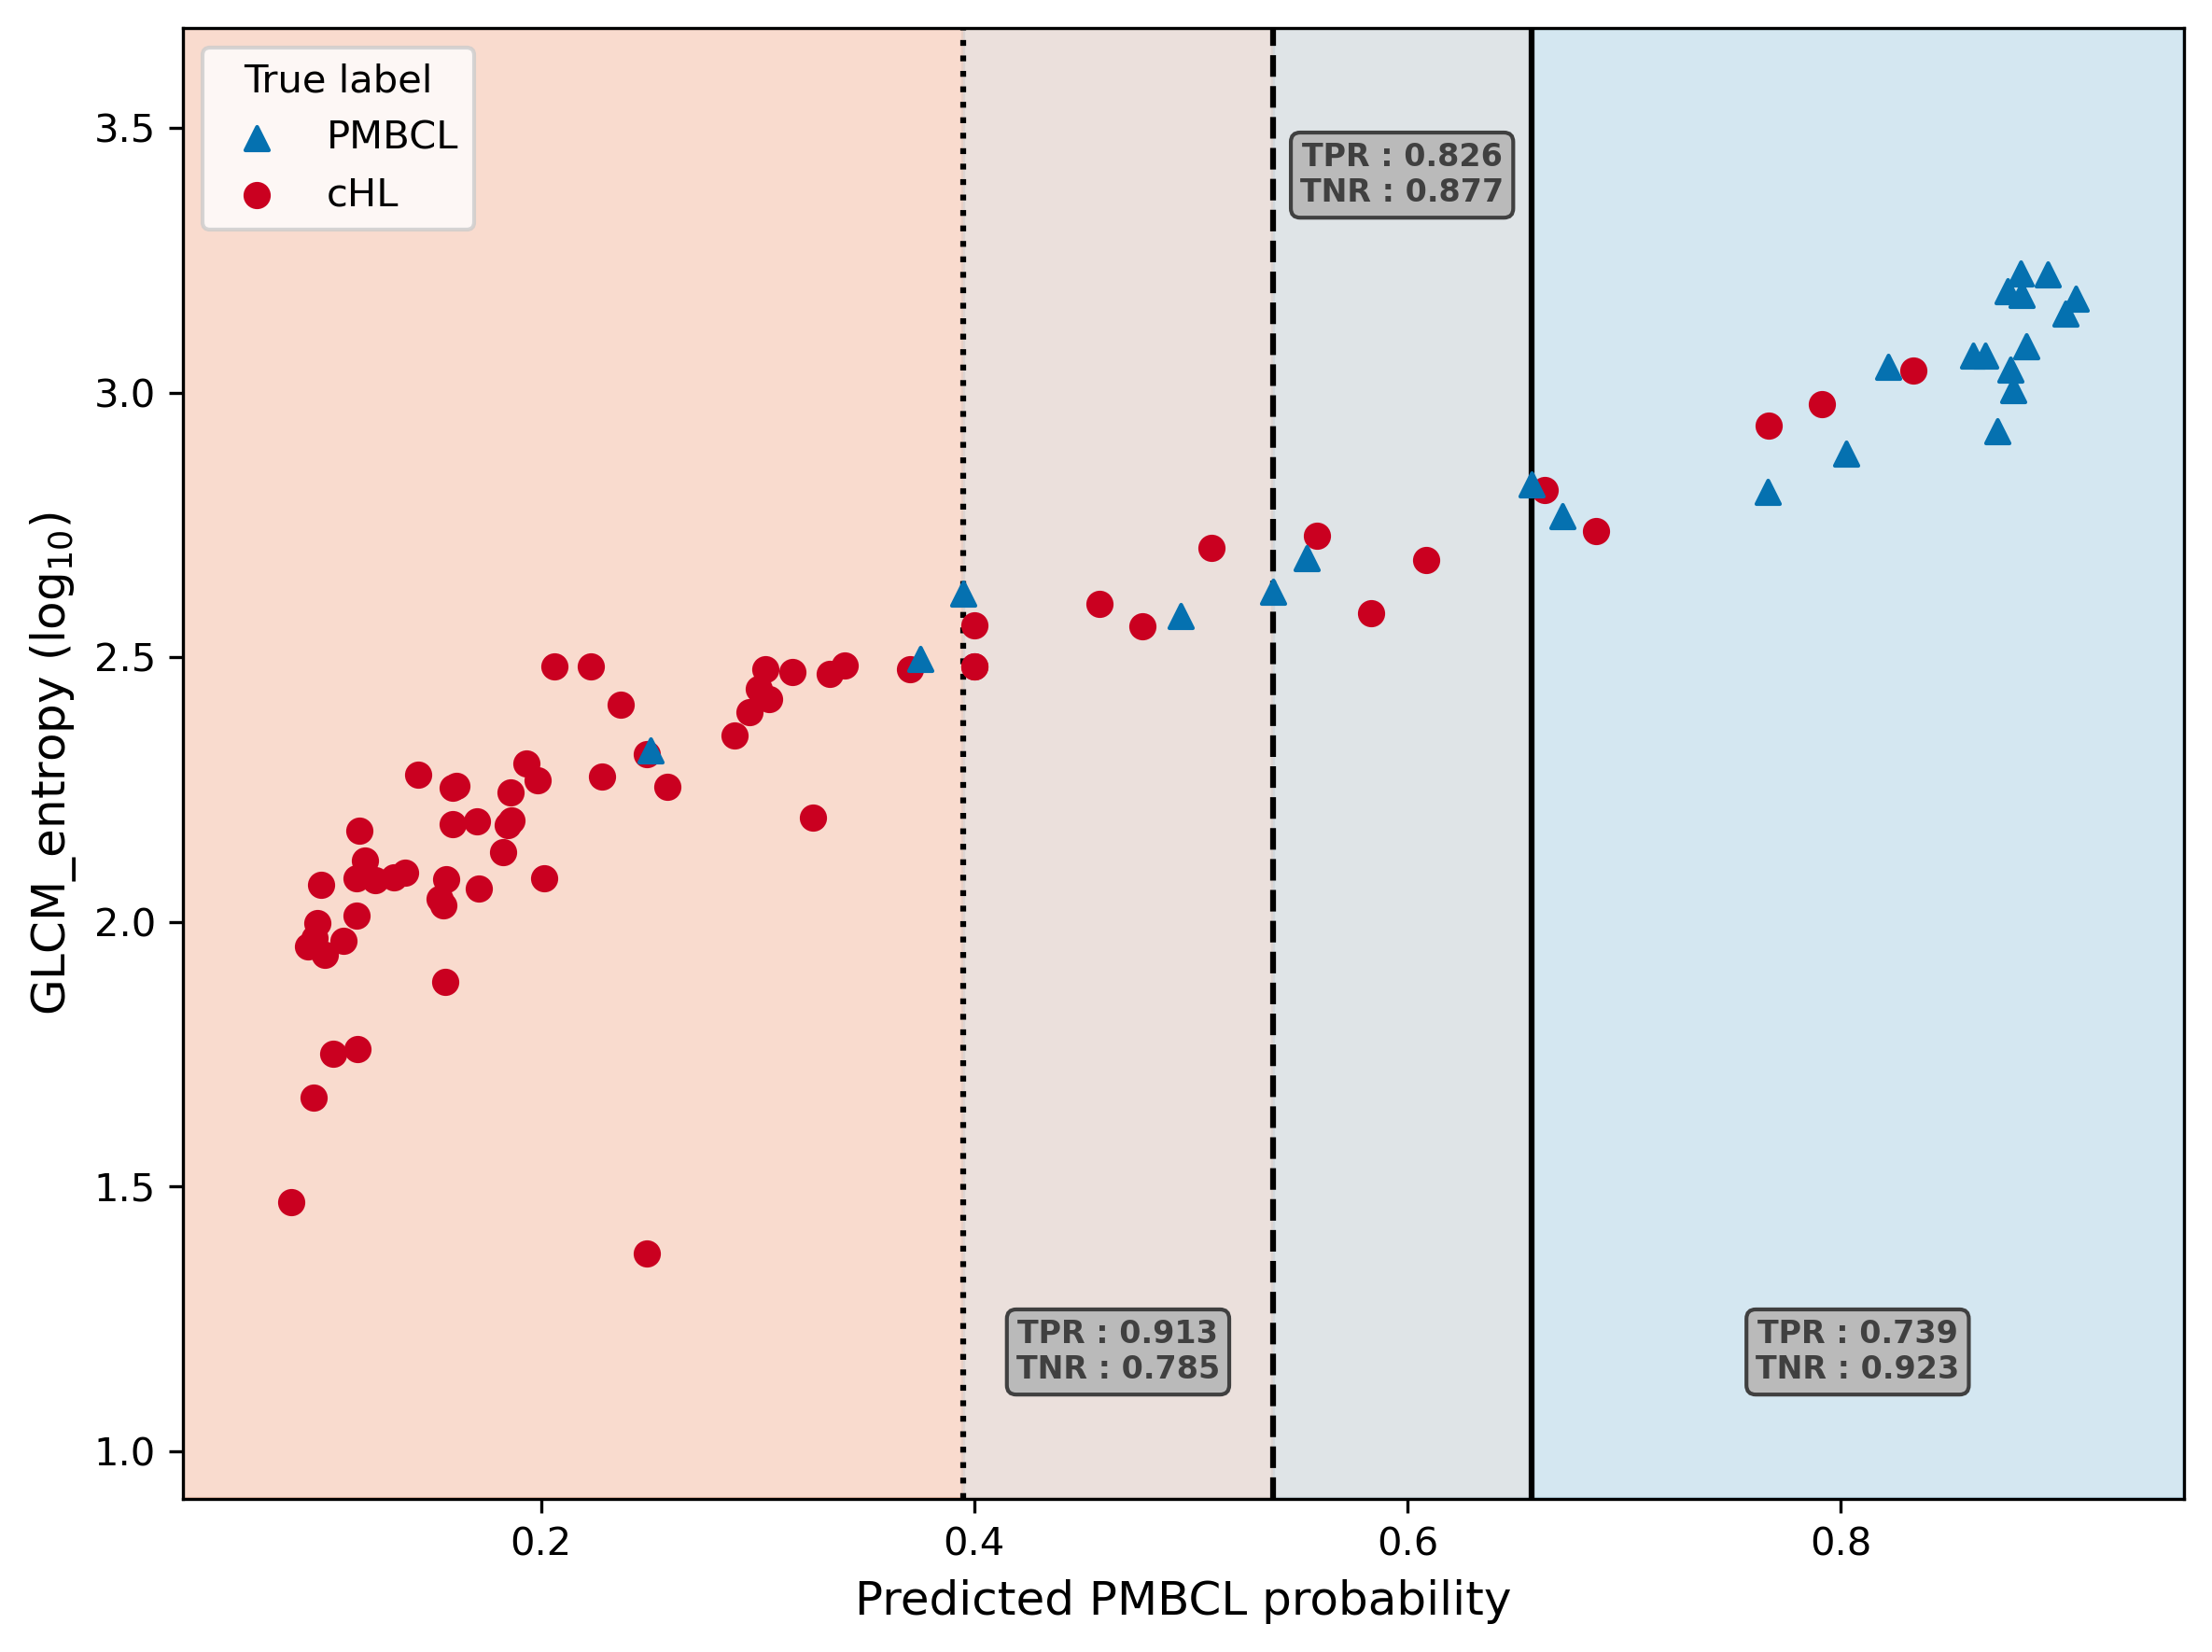

In [18]:
plot_decision_boundary ( y_true   = y_train , 
                         y_scores = gausproc_scores ,
                         X_feat    = scaler . inverse_transform (X_train) [:,6] ,
                         feat_name = "GLCM_entropy ($\log_{10}$)" ,
                         strategy = "recall" , labels = LABELS , 
                         save_figure = False )

## Random forest

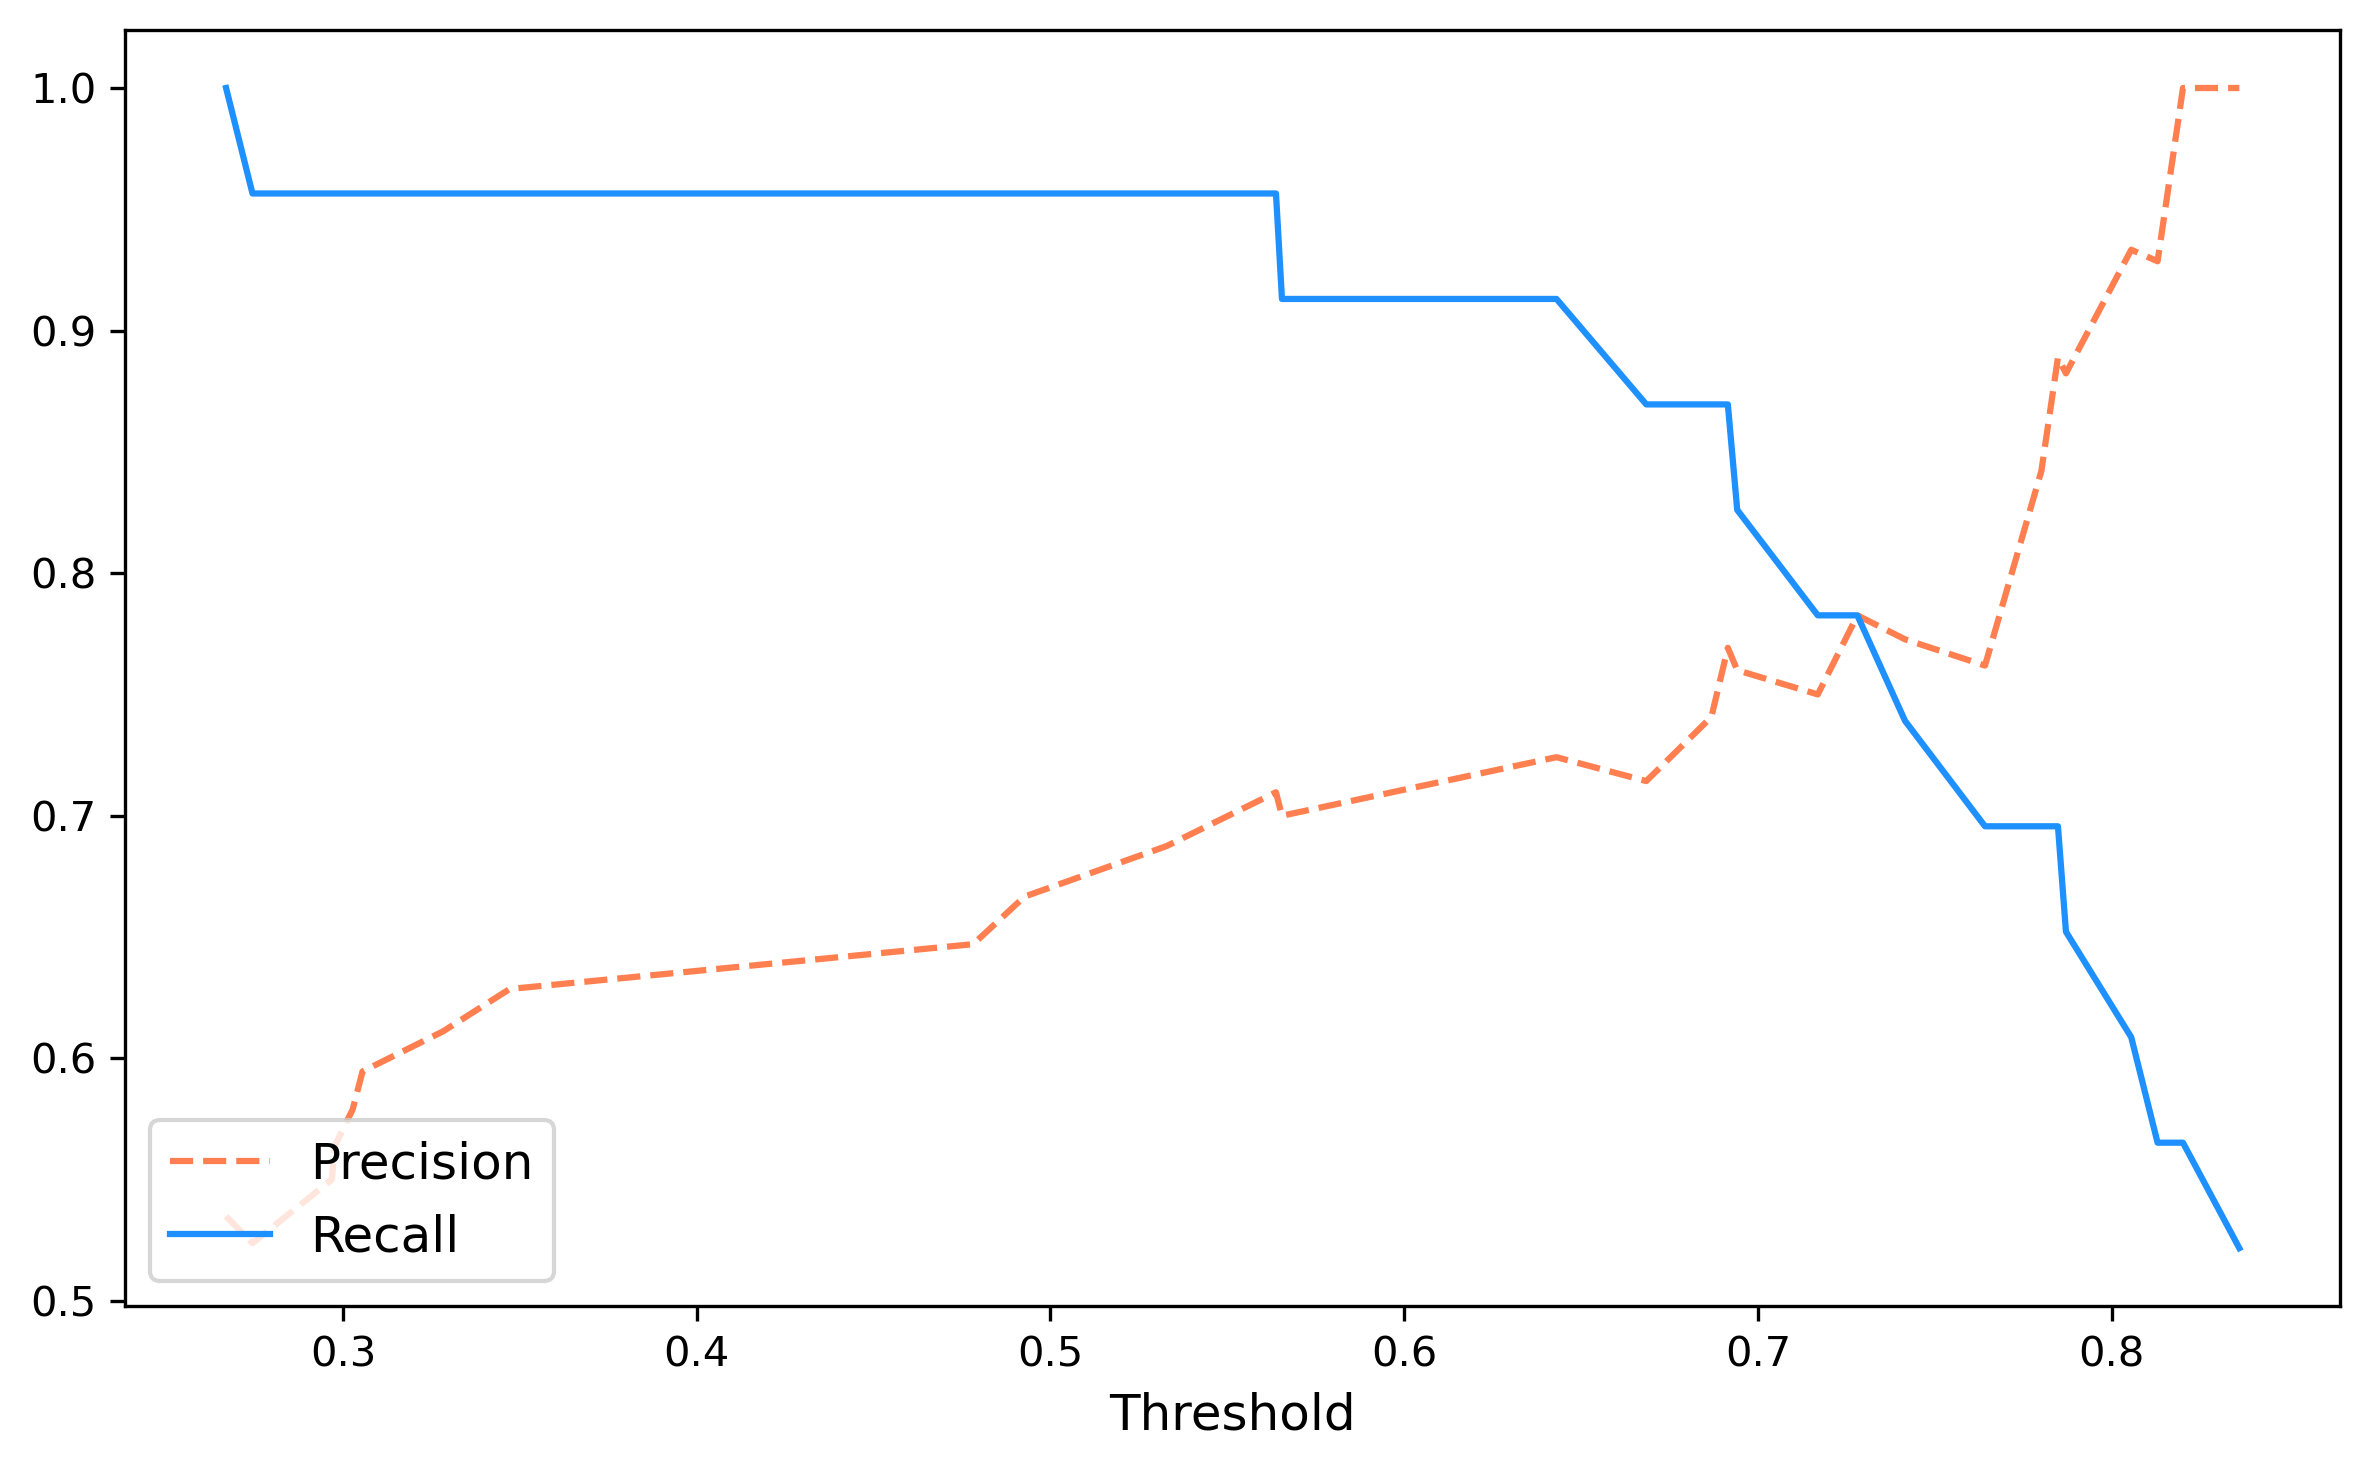

In [19]:
clf_rndfrs = RandomForestClassifier ( n_estimators = 100, max_depth = 1 )
clf_rndfrs . fit ( X_train_res, y_train_res )

rndfrs_scores = clf_rndfrs . predict_proba ( X_train )
y_pred_rndfrs, _ = custom_predictions ( y_true   = y_train , 
                                        y_scores = rndfrs_scores , 
                                        recall_score    = 0.9  , 
                                        precision_score = None ,
                                        show_curves = True  , 
                                        save_figure = False )

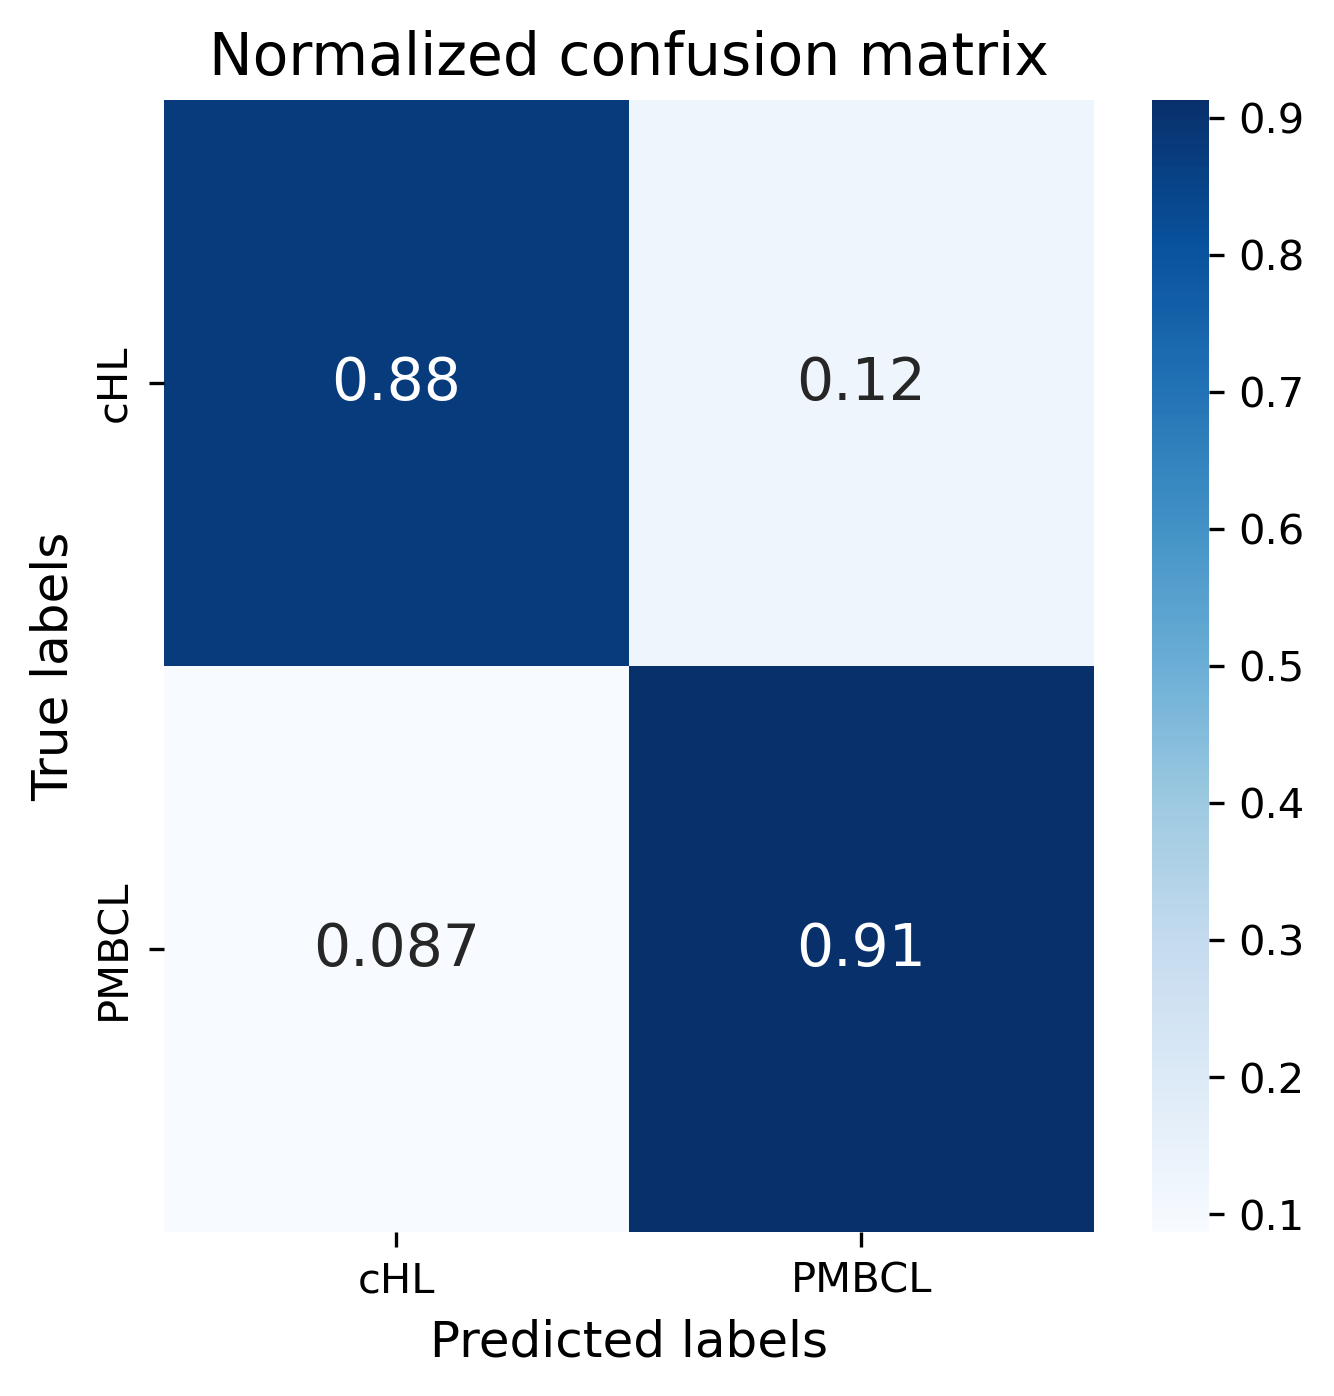

In [20]:
conf_matrix_train = confusion_matrix ( y_train, y_pred_rndfrs )

plot_conf_matrices ( conf_matrix = conf_matrix_train, labels = LABELS, show_matrix = "norm", save_figure = False )

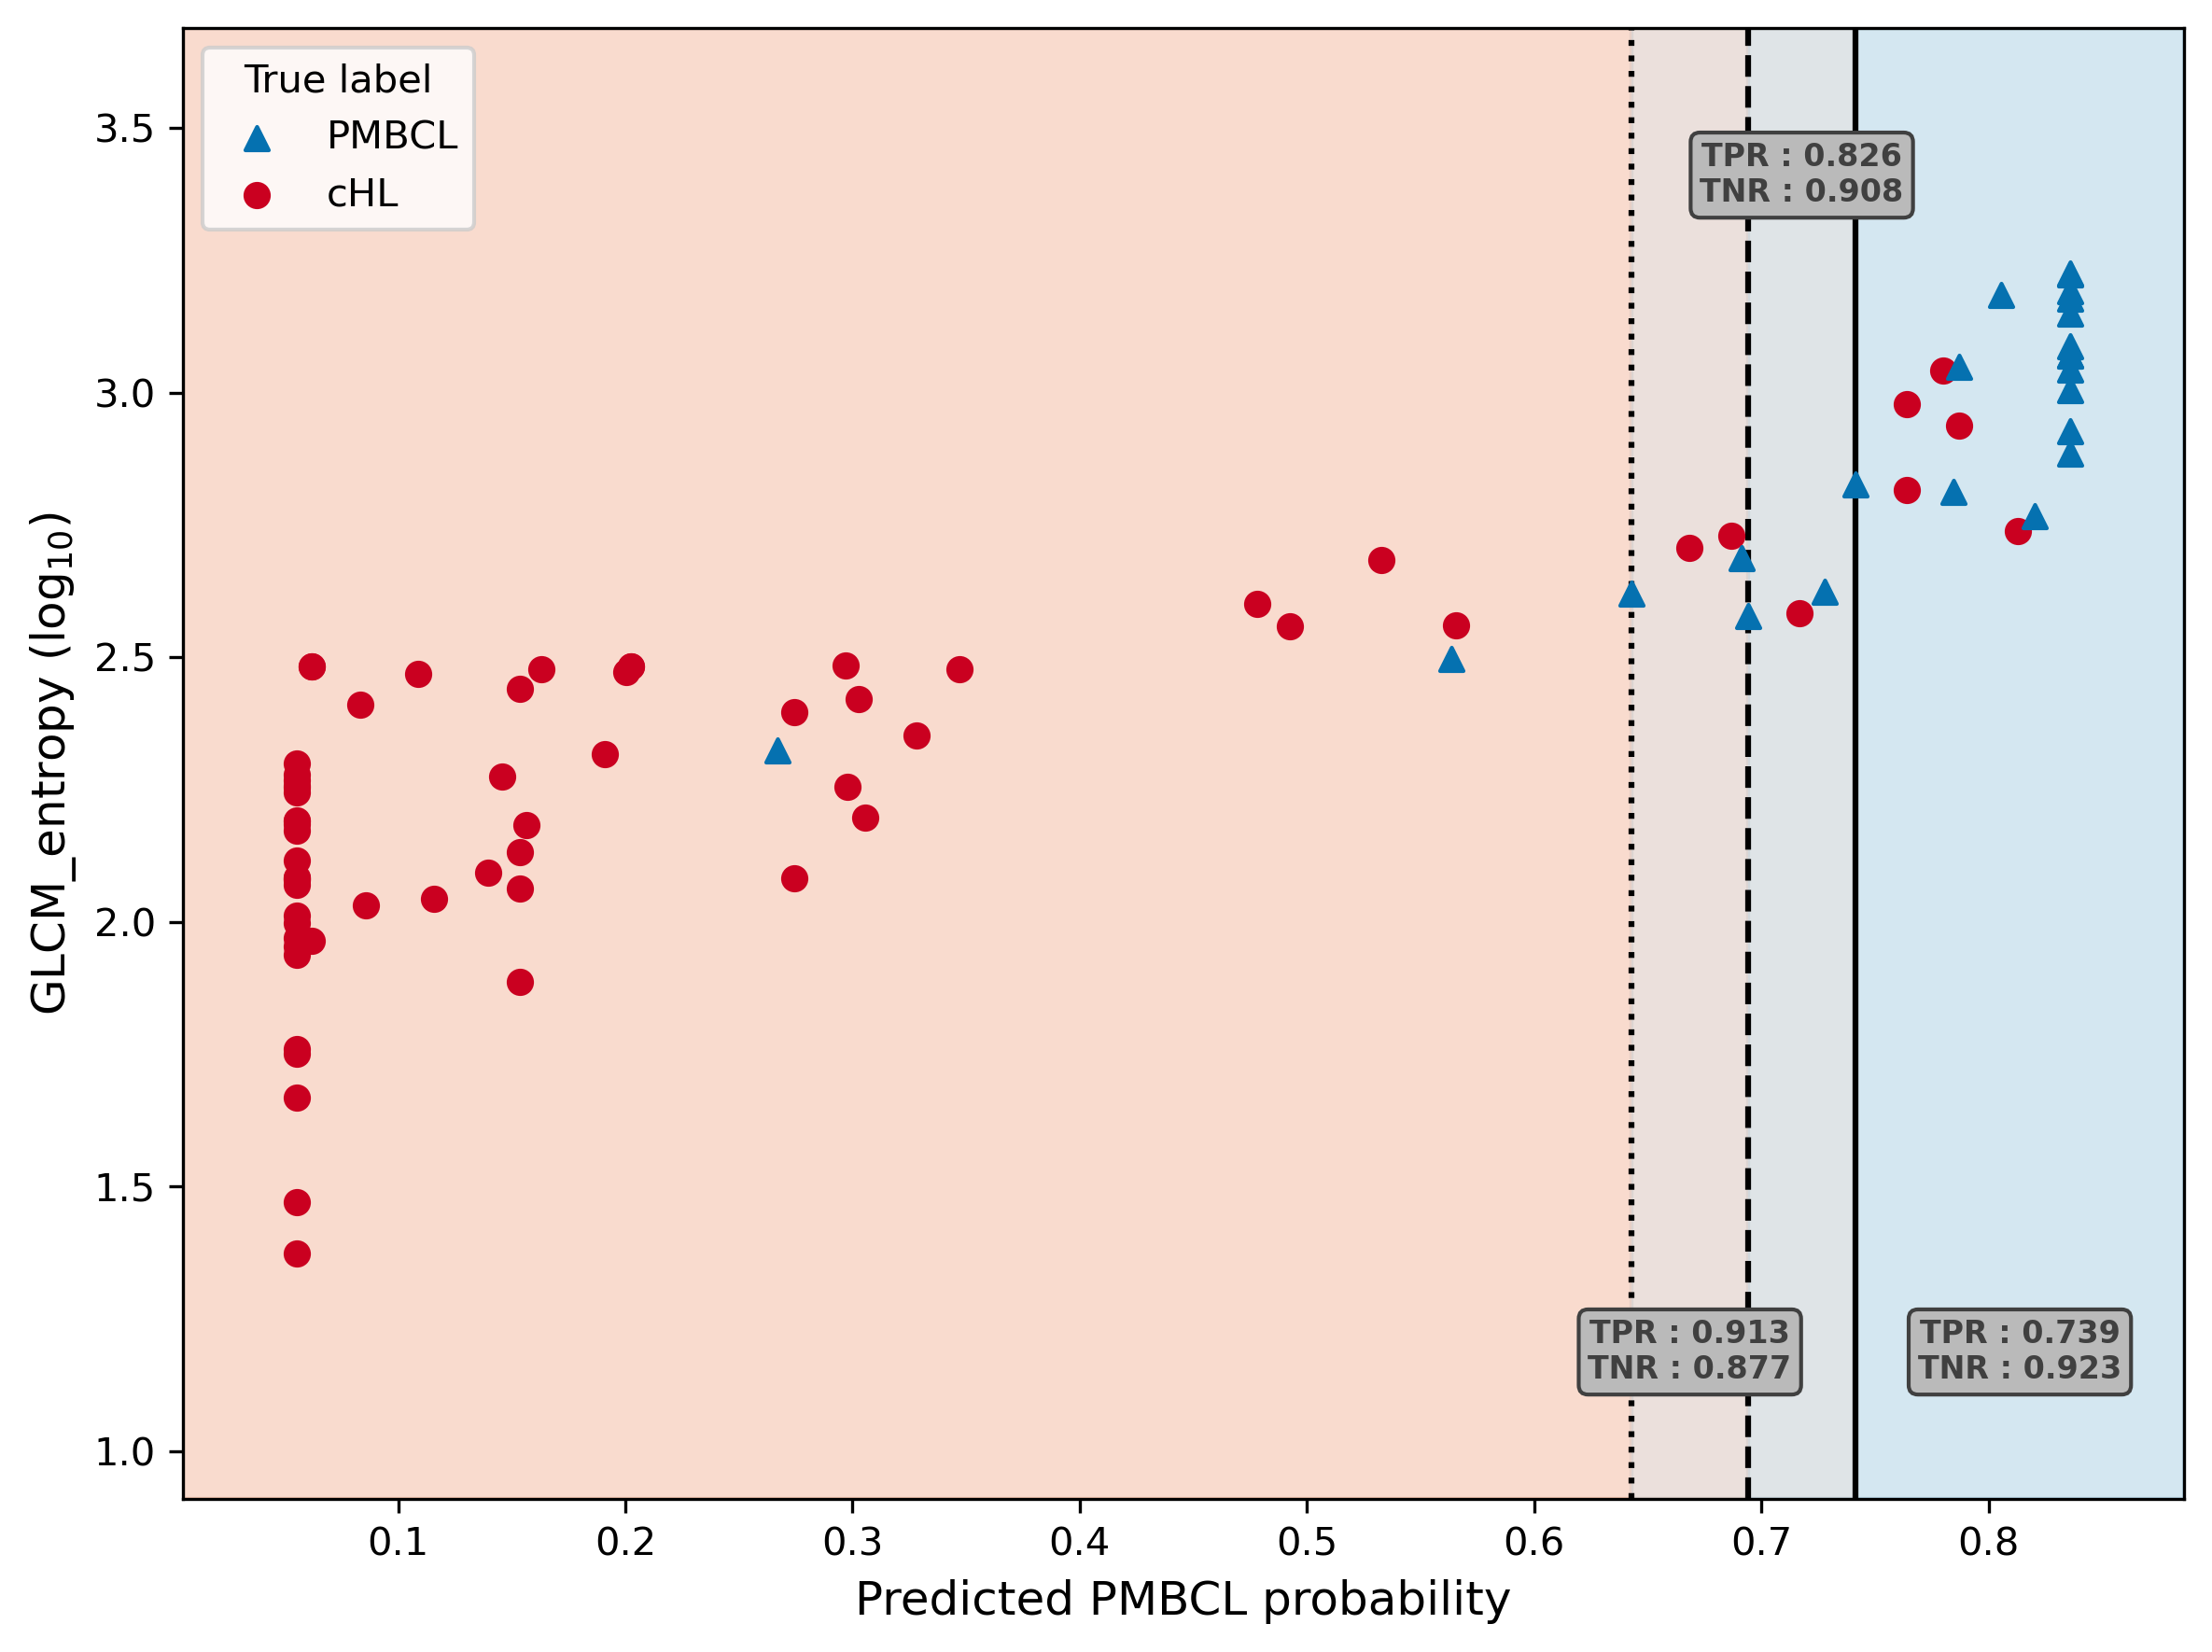

In [21]:
plot_decision_boundary ( y_true   = y_train , 
                         y_scores = rndfrs_scores ,
                         X_feat    = scaler . inverse_transform (X_train) [:,6] ,
                         feat_name = "GLCM_entropy ($\log_{10}$)" ,
                         strategy = "recall" , labels = LABELS , 
                         save_figure = False )

## Gradient BDT

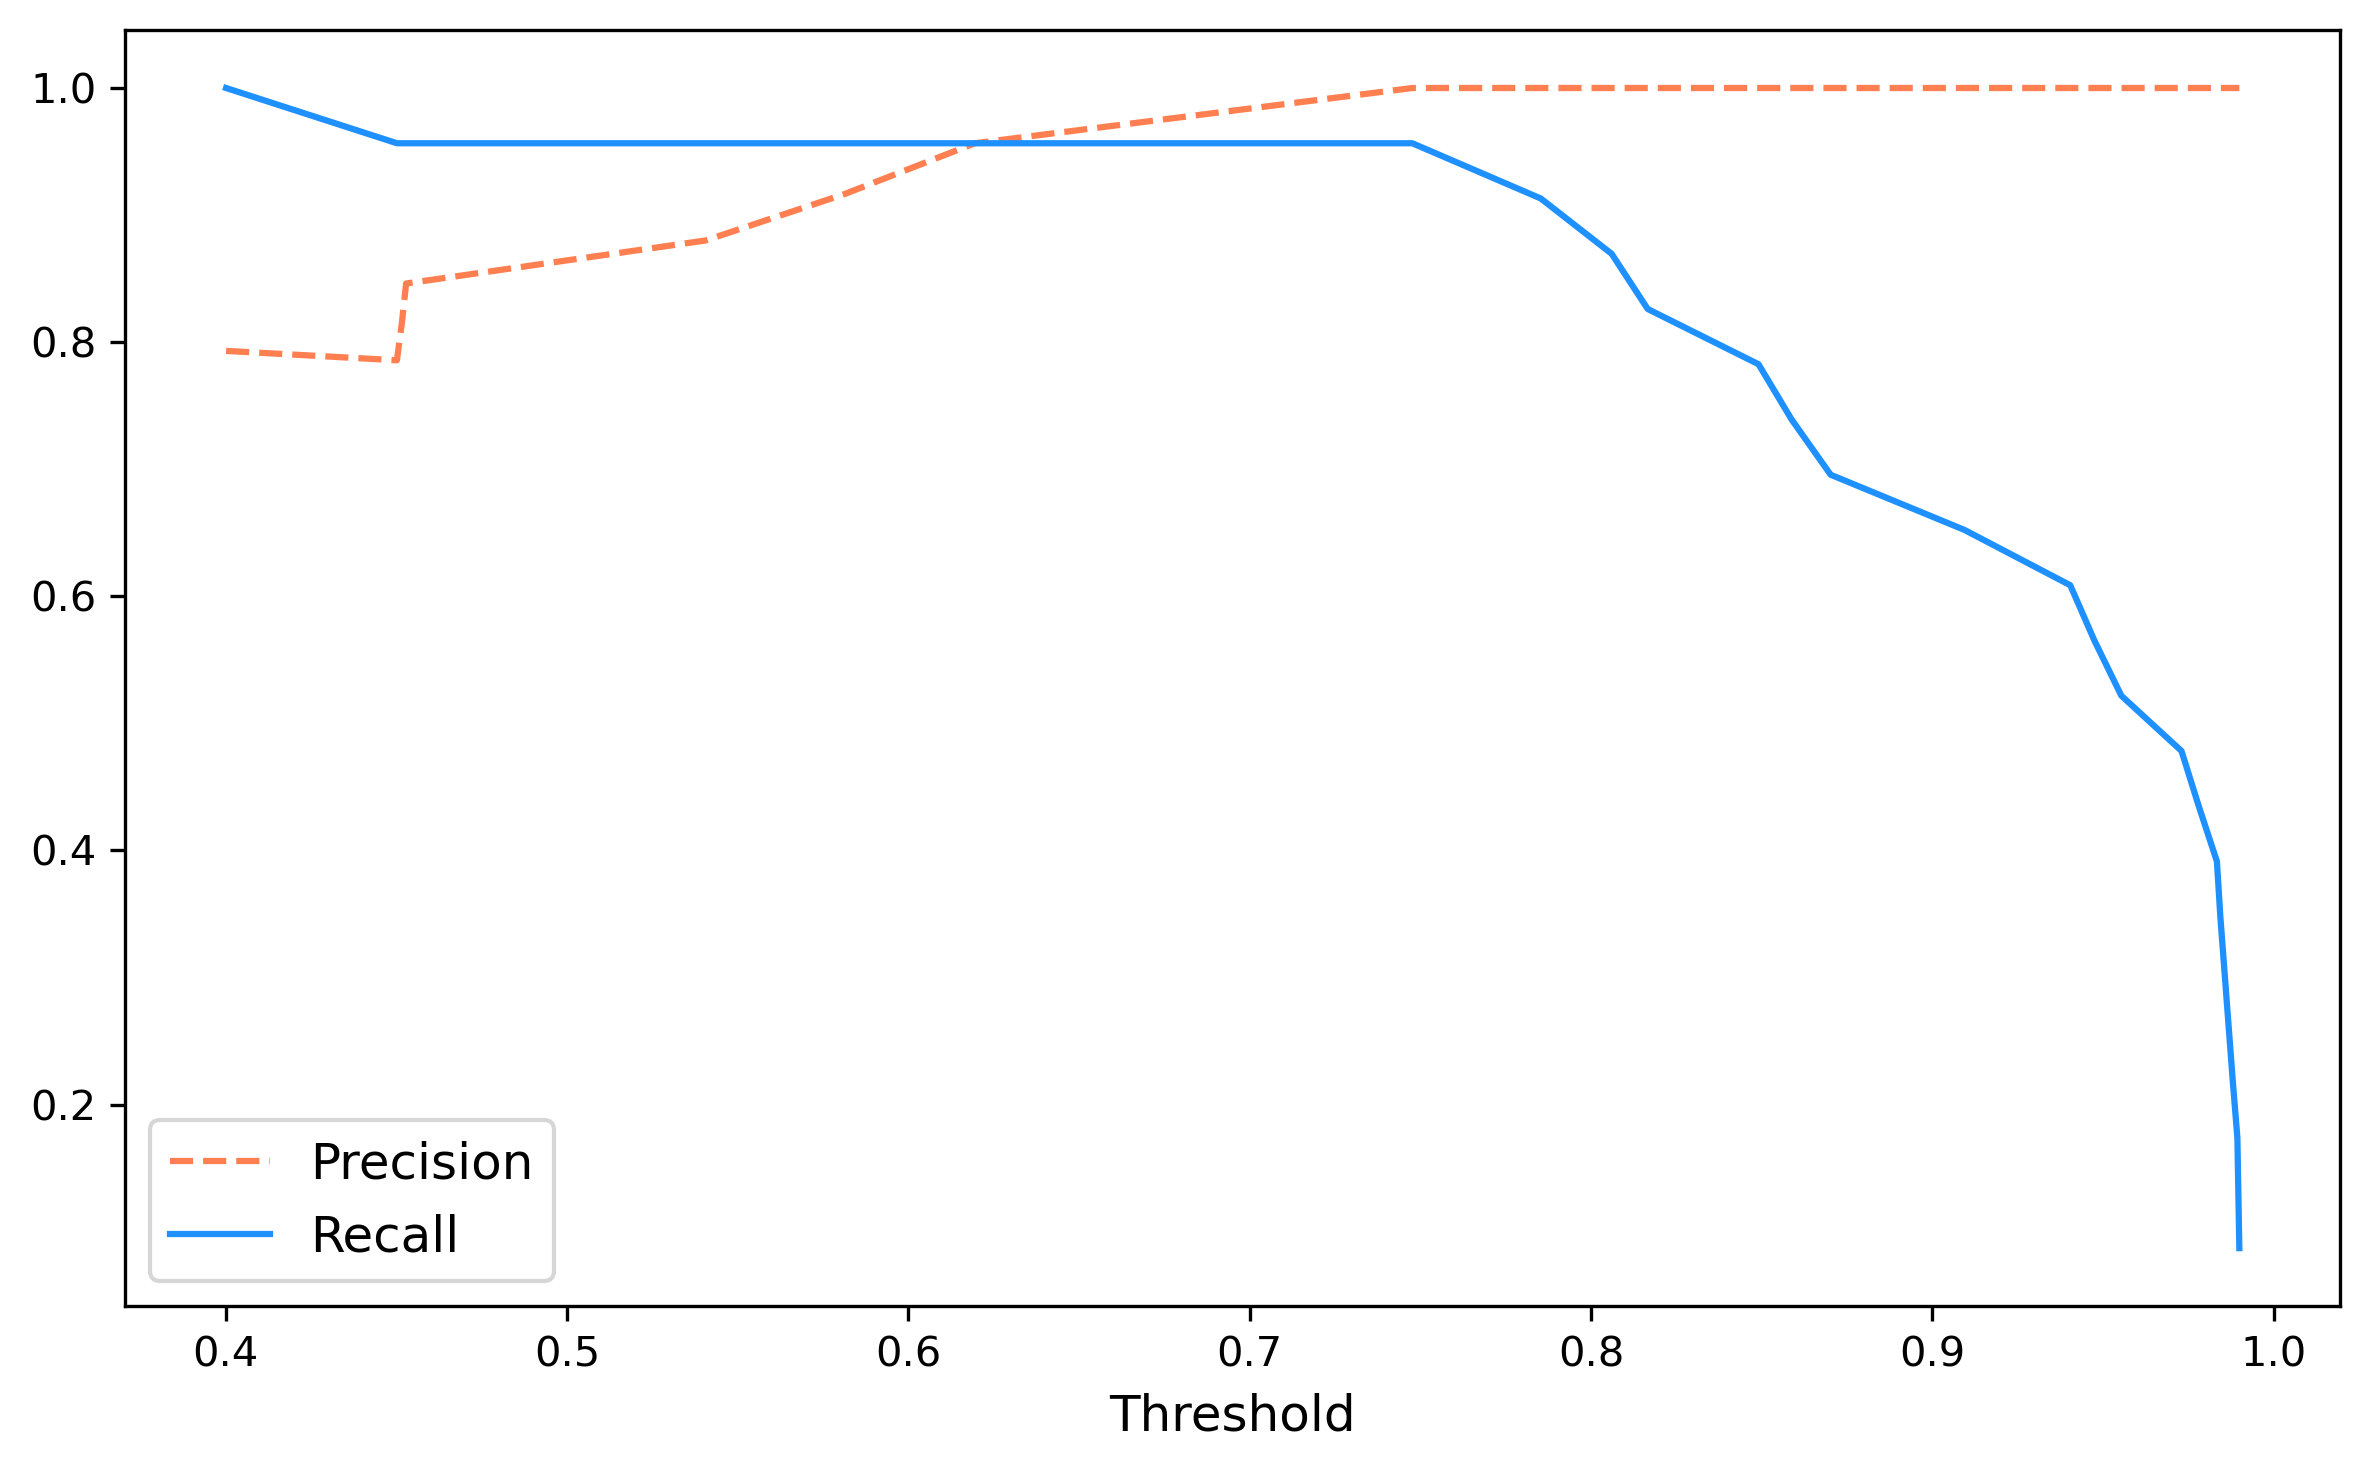

In [22]:
clf_gradbdt = GradientBoostingClassifier ( learning_rate = 0.2, n_estimators = 100, max_depth = 1 )
clf_gradbdt . fit ( X_train_res, y_train_res )

gradbdt_scores = clf_gradbdt . predict_proba ( X_train )
y_pred_gradbdt, _ = custom_predictions ( y_true   = y_train , 
                                        y_scores = gradbdt_scores , 
                                        recall_score    = 0.9  , 
                                        precision_score = None ,
                                        show_curves = True  , 
                                        save_figure = False )

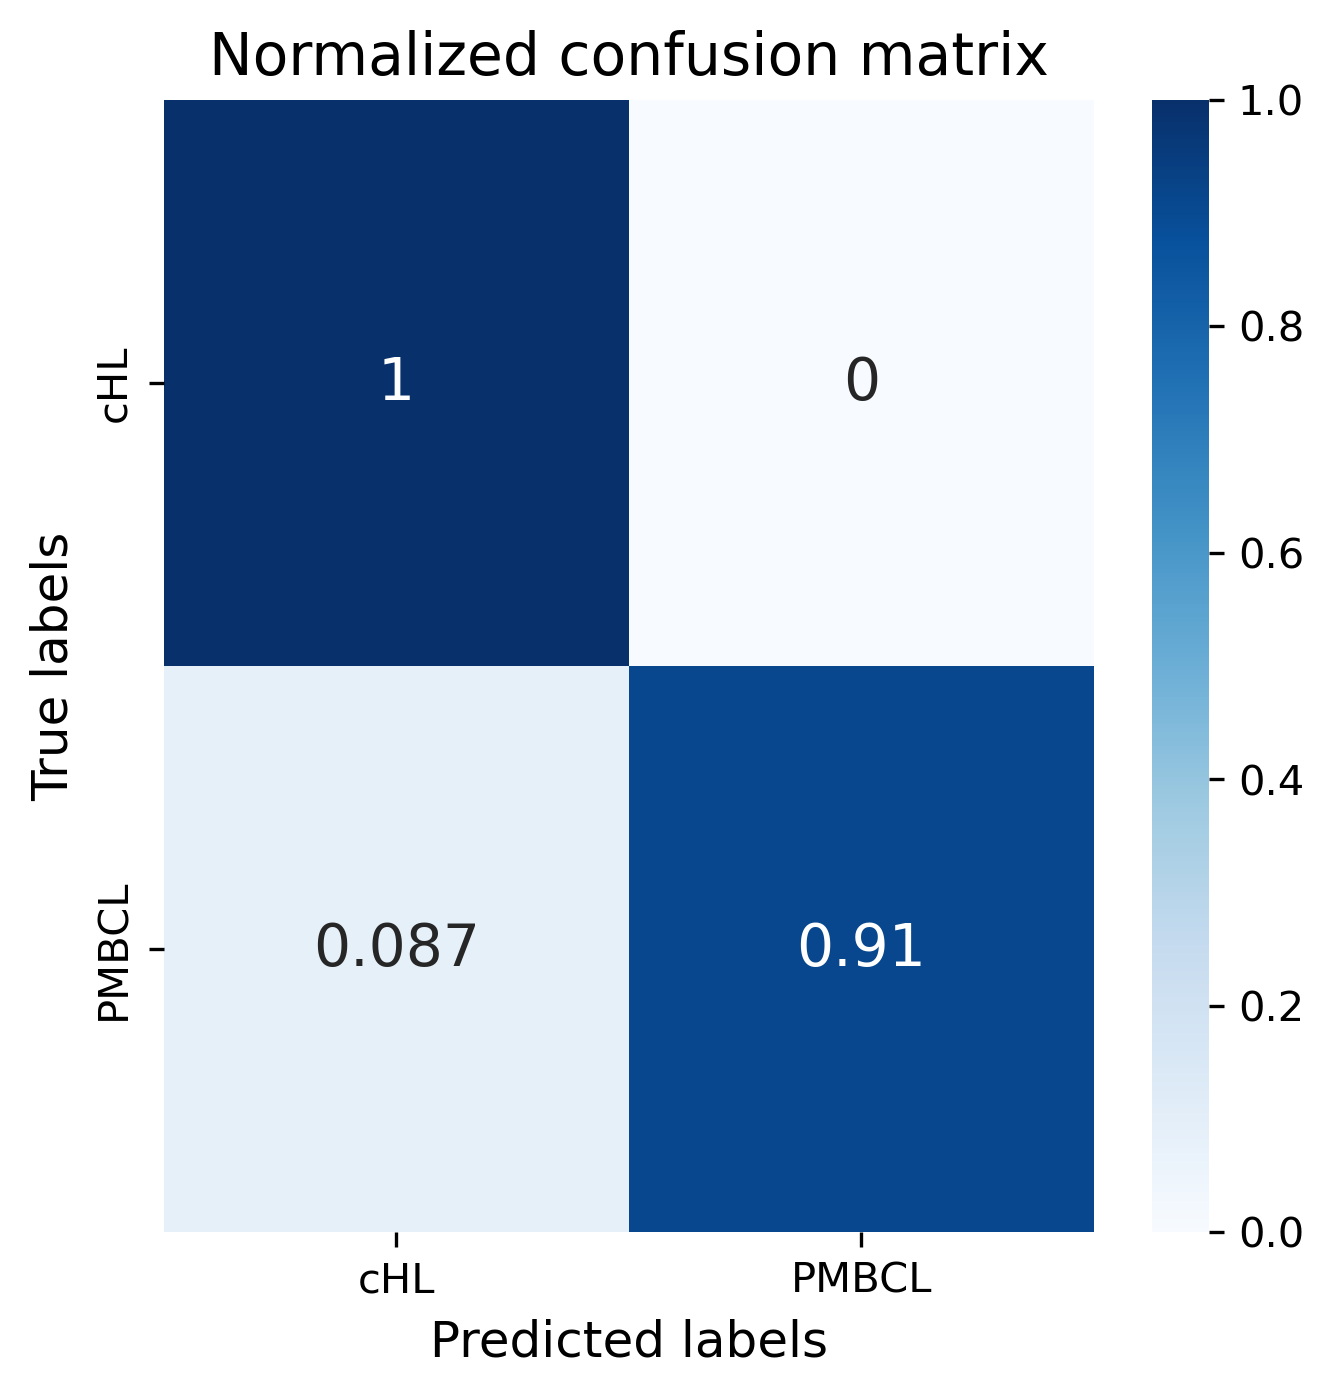

In [23]:
conf_matrix_train = confusion_matrix ( y_train, y_pred_gradbdt )

plot_conf_matrices ( conf_matrix = conf_matrix_train, labels = LABELS, show_matrix = "norm", save_figure = False )

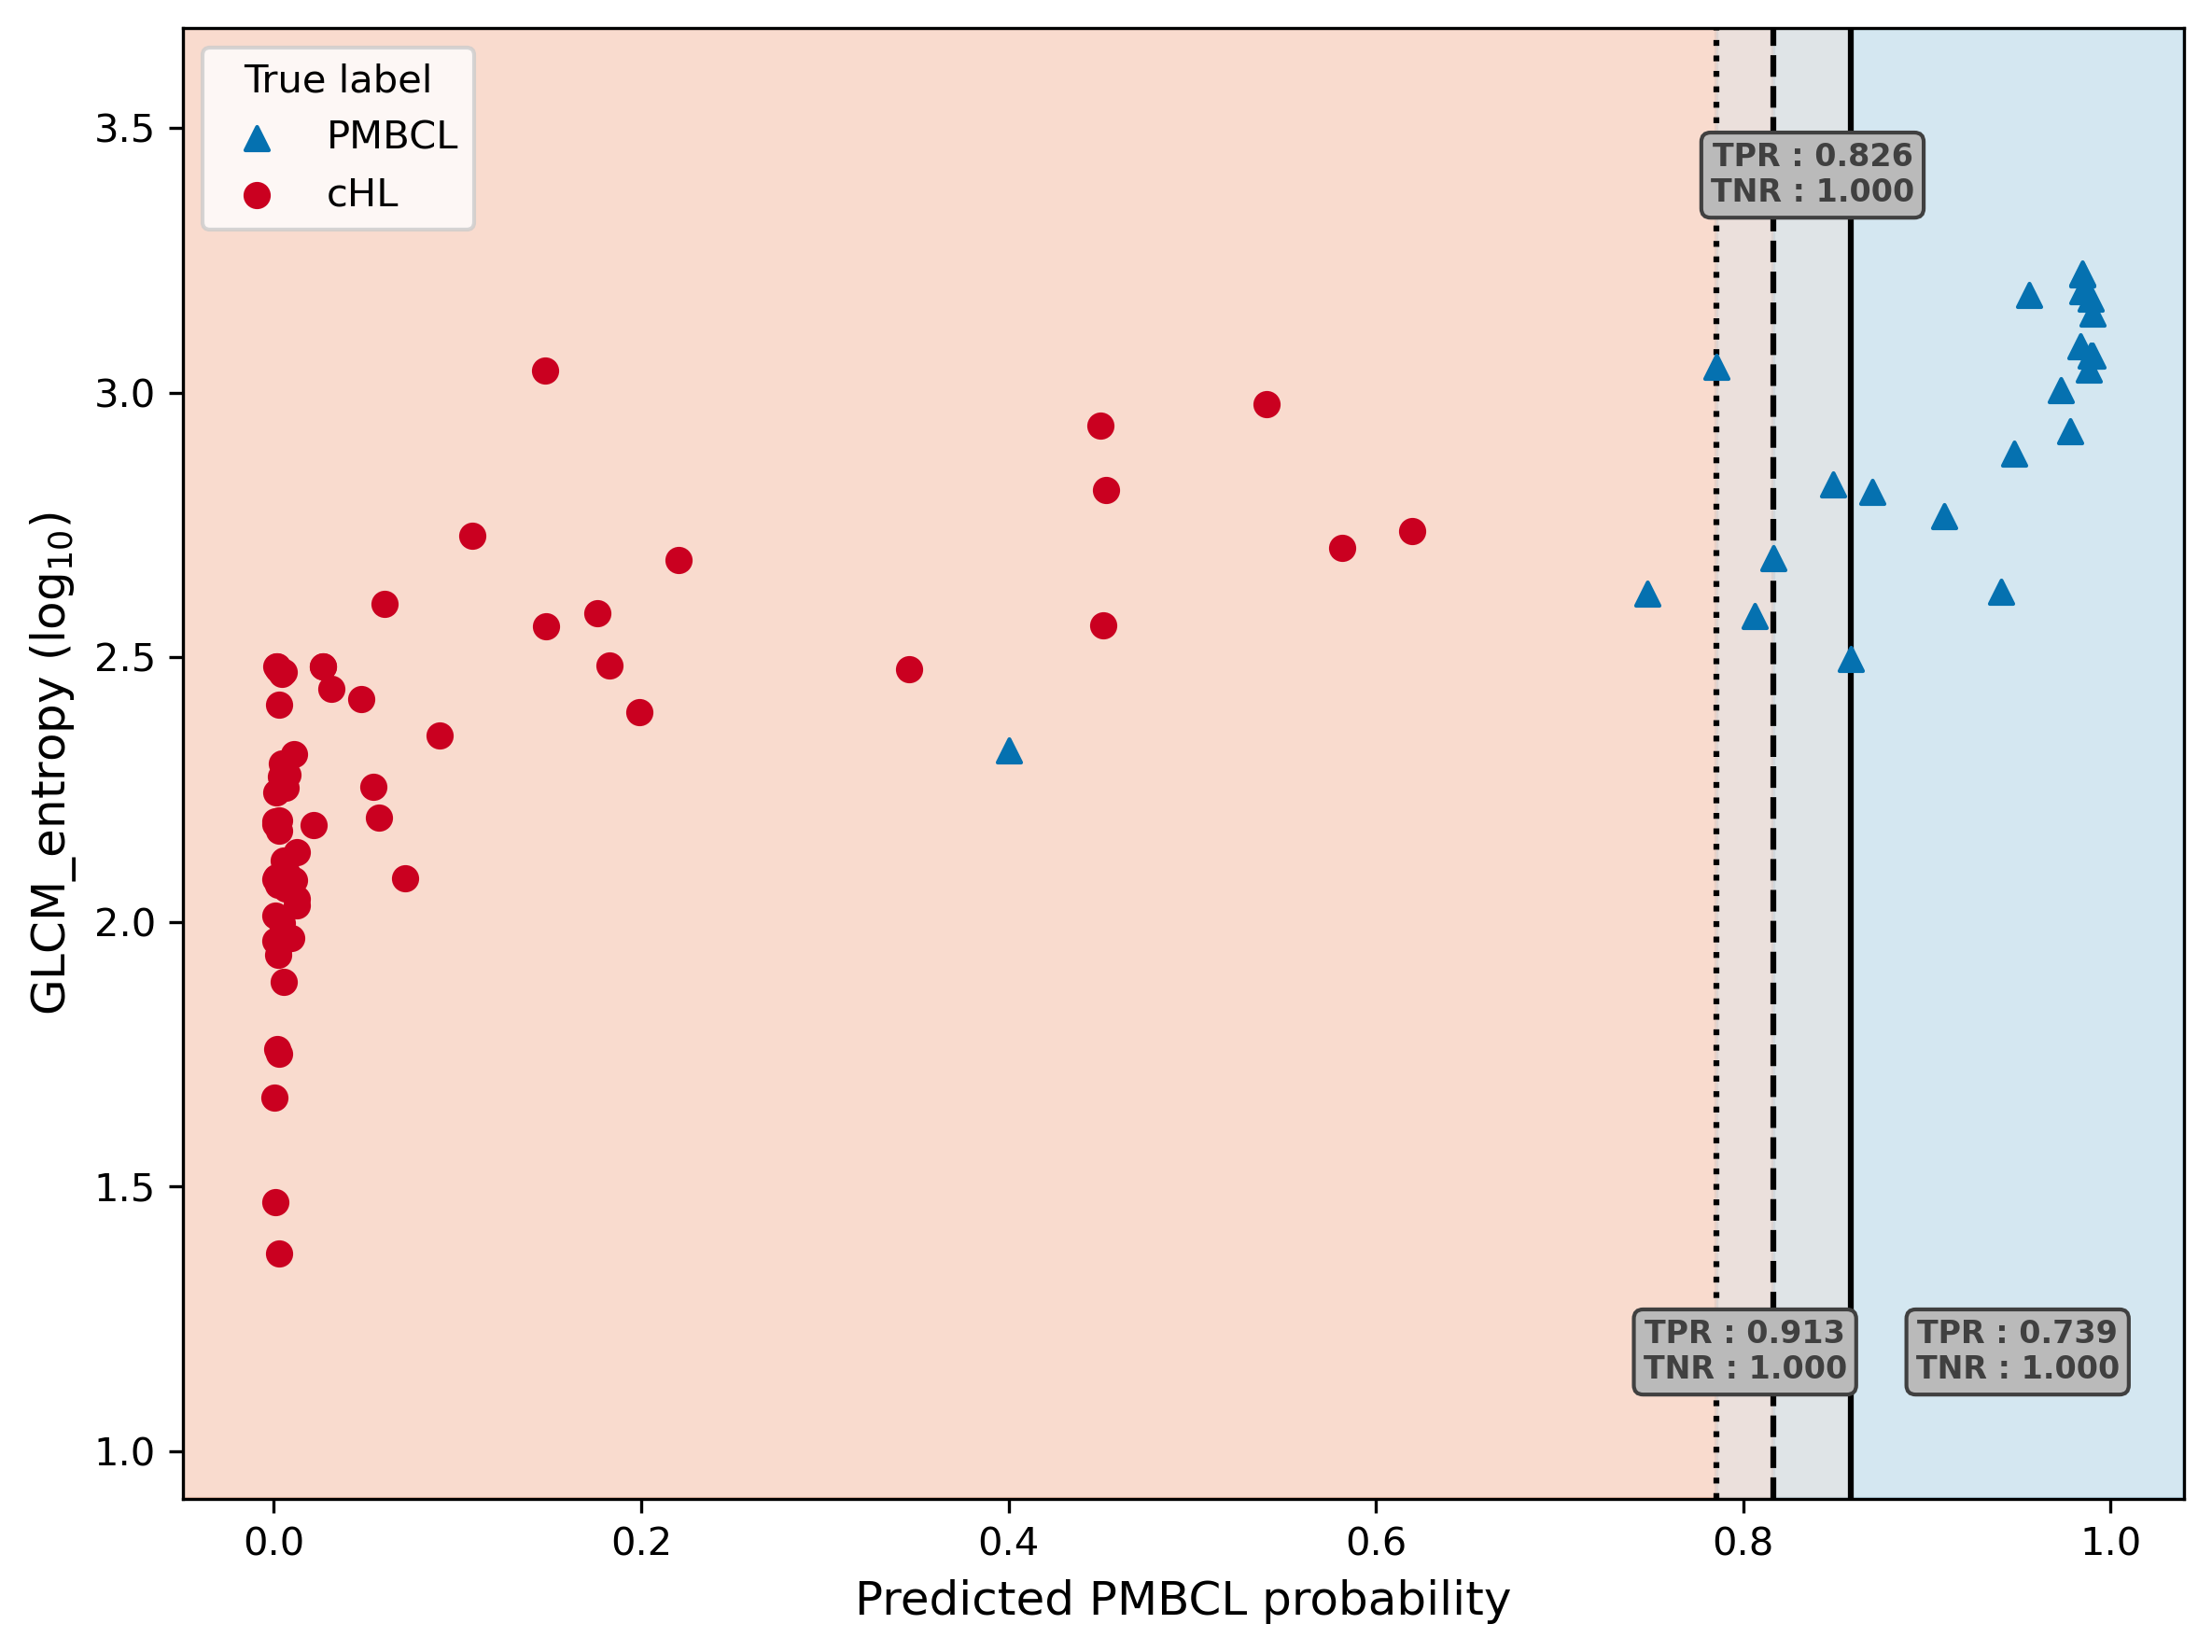

In [24]:
plot_decision_boundary ( y_true   = y_train , 
                         y_scores = gradbdt_scores ,
                         X_feat    = scaler . inverse_transform (X_train) [:,6] ,
                         feat_name = "GLCM_entropy ($\log_{10}$)" ,
                         strategy = "recall" , labels = LABELS , 
                         save_figure = False )

## Models comparison

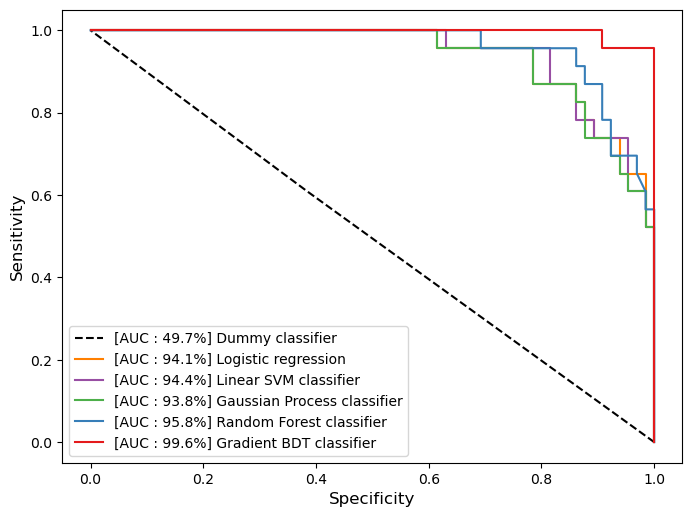

In [25]:
auc_scores = list()

model_scores = [dummy_scores[:,1], logreg_scores[:,1], linsvm_scores[:,1], gausproc_scores[:,1], rndfrs_scores[:,1], gradbdt_scores[:,1]]
colors = ["black", "#ff7f00", "#984ea3", "#4daf4a",  "#377eb8", "#e41a1c"]
styles = ["--", "-", "-", "-", "-", "-"]
labels = ["Dummy classifier", "Logistic regression", 
          "Linear SVM classifier", "Gaussian Process classifier", 
          "Random Forest classifier", "Gradient BDT classifier"]

plt.figure (figsize = (8,6), dpi = 100)
plt.xlabel ("Specificity", fontsize = 12)
plt.ylabel ("Sensitivity", fontsize = 12)
for score, col, stl, lbl in zip (model_scores, colors, styles, labels):
  auc = roc_auc_score ( y_train, score )
  auc_scores . append ( auc )
  fpr, tpr, _ = roc_curve ( y_train, score )
  plt.plot (1 - fpr, tpr, color = col, linestyle = stl, label = f"[AUC : {100*auc:.1f}%] {lbl}")
plt.legend (loc = "lower left", fontsize = 10)
plt.show()

## Performance evaluation

In [26]:
models = [clf_dummy, clf_logreg, clf_linsvm, clf_gausproc, clf_rndfrs, clf_gradbdt]

best_model = models [ np.argmax (auc_scores) ]

best_model . fit ( X_train_res, y_train_res )
best_scores = best_model . predict_proba ( X_train )

In [27]:
best_predictions, threshold = custom_predictions ( y_train, best_scores, recall_score = 0.8 )

y_proba_test = best_model . predict_proba ( X_test )
y_pred_test  = (y_proba_test[:,1] >= threshold)

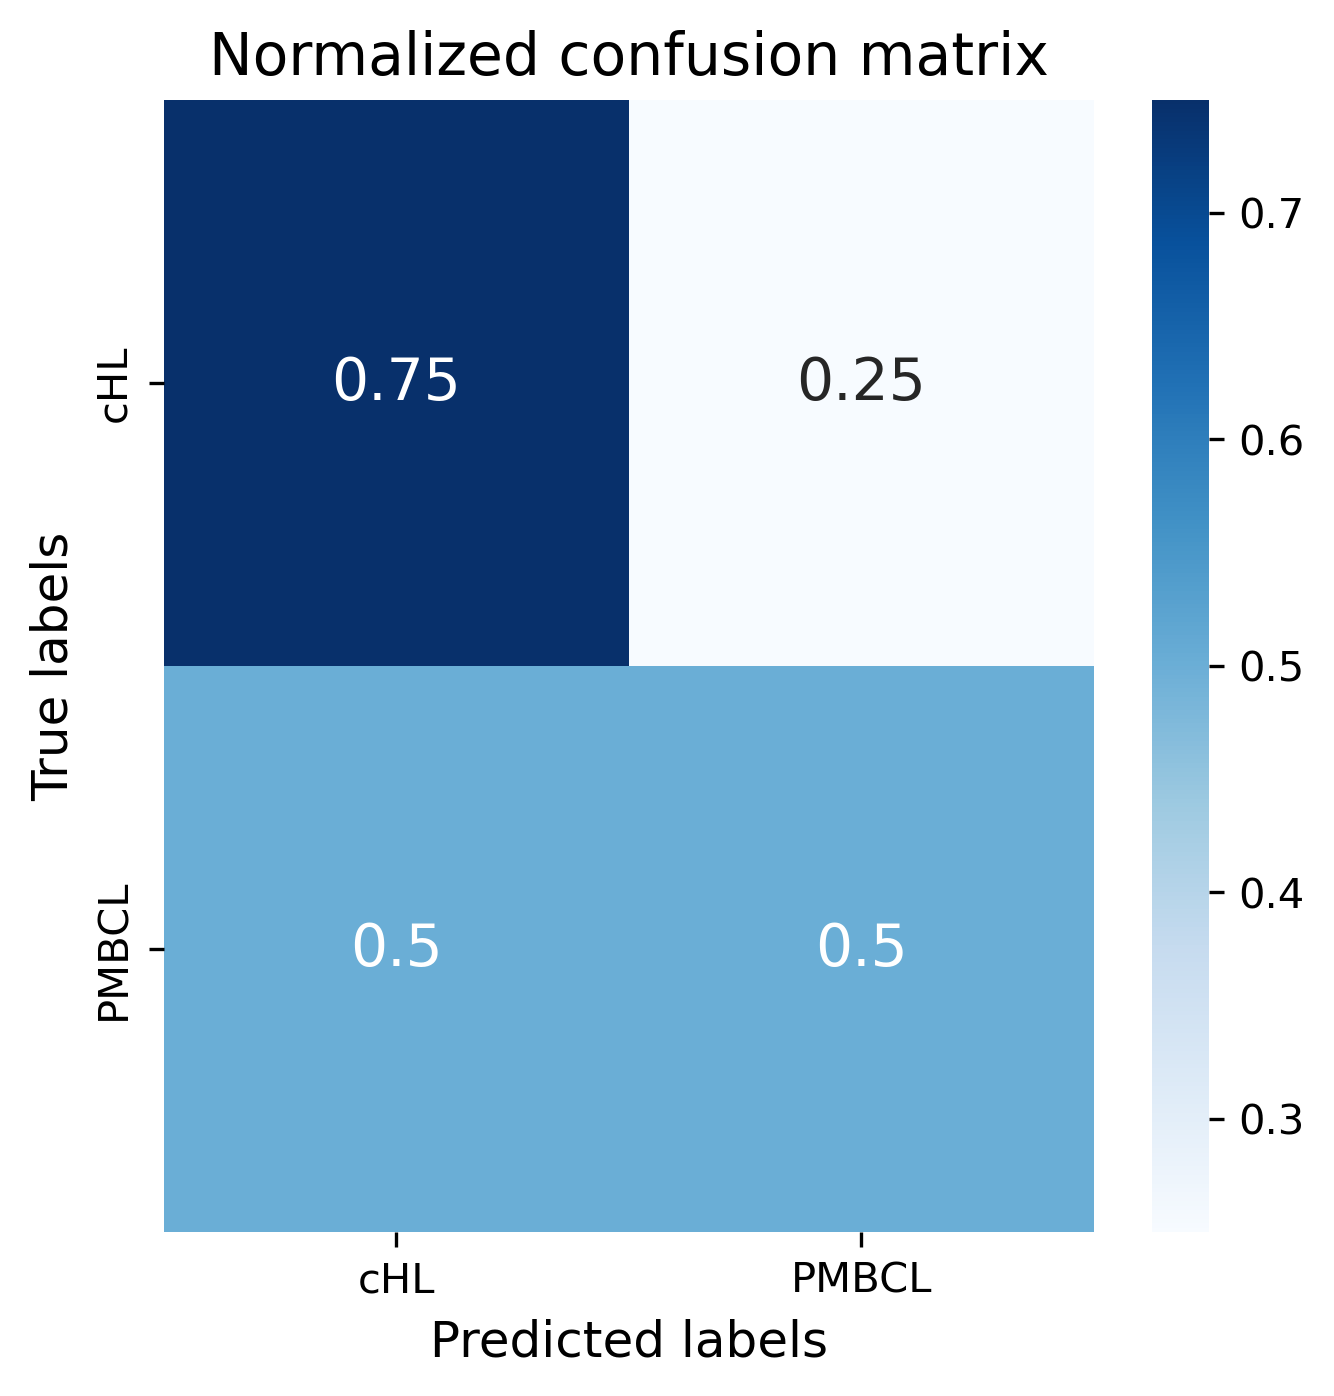

In [28]:
conf_matrix_test = confusion_matrix ( y_test, y_pred_test )

plot_conf_matrices ( conf_matrix = conf_matrix_test, labels = LABELS, show_matrix = "norm", save_figure = False )